In [40]:
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split 
from sklearn.datasets import fetch_lfw_people 
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


# DEFINE MODULAR PCA

In [41]:
def get_length(n):
    start = int(np.sqrt(n))
    while start > 1:
        if n % start == 0:
            break
        else:
            start -= 1
    return start, n // start

In [42]:
def cut_image(X, num_image=4, shape=(62,47)):
    height, width = shape
    num_width, num_height = get_length(num_image)
    part_width = width // num_width
    part_height = height // num_height

    X_cut = []

    for i in range(X.shape[0]):
        image = X[i].reshape(shape)
        for k in range(num_width):
            for j in range(num_height):
                left = j * part_width
                upper = k * part_height
                right = left + part_width
                lower = upper + part_height

                # Crop the image to get the part
                part = image[upper:lower, left:right]

                pixels = np.reshape(part, [1, part_width * part_height])
                pixels = np.asarray(pixels)

                if k == 0 and j == 0:
                    X_i = pixels
                else:
                    X_i = np.hstack([X_i, pixels])

        if len(X_cut) == 0:
            X_cut = X_i
        else:
            X_cut = np.vstack([X_cut, X_i])

    return X_cut

In [43]:
class ModularPCA:
    def __init__(self, n_components, num_image=4, shape_image=(62,47)):
        self.n_components = n_components
        self.shape = shape_image
        self.num_image = num_image

    def fit(self, X):
        self.X = cut_image(X, self.num_image, self.shape)
        self.pca = PCA(n_components=self.n_components, random_state=42)
        self.pca.fit(self.X)

    def transform(self, X):
        X_cut = cut_image(X, self.num_image, self.shape)
        return self.pca.transform(X_cut)

    def fit_transform(self, X):
        self.fit(X)
        return self.pca.fit_transform(self.X)

# LOAD DATASET

In [44]:
lfw_people = fetch_lfw_people(min_faces_per_person = 70, funneled=False) 
  
n_samples, h, w = lfw_people.images.shape 
  
X = lfw_people.data 
n_features = X.shape[1] 
  
y = lfw_people.target 
target_names = lfw_people.target_names 
n_classes = target_names.shape[0] 
  
# Print Details about dataset 
print("Number of Data Samples: % d" % n_samples) 
print("Size of a data sample: % d" % n_features) 
print("Number of Class Labels: % d" % n_classes)

Number of Data Samples:  1288
Size of a data sample:  2914
Number of Class Labels:  7


In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42, stratify=y) 

In [46]:
n_components = 150
  
pca = PCA(n_components=n_components)
X_train_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.transform(X_test)

# Euclidean

In [47]:
y_predict = []
for i in range(len(X_test_reduced)):
    min_ = np.argmin(np.sqrt(np.sum((X_train_reduced - X_test_reduced[i])**2,axis=1)))
    y_predict.append(y_train[min_])

In [48]:
print(classification_report(y_test, y_predict, target_names = target_names)) 

                   precision    recall  f1-score   support

     Ariel Sharon       0.29      0.26      0.28        19
     Colin Powell       0.46      0.53      0.49        59
  Donald Rumsfeld       0.41      0.40      0.41        30
    George W Bush       0.59      0.64      0.62       133
Gerhard Schroeder       0.16      0.11      0.13        27
      Hugo Chavez       0.25      0.11      0.15        18
       Tony Blair       0.36      0.39      0.37        36

         accuracy                           0.47       322
        macro avg       0.36      0.35      0.35       322
     weighted avg       0.45      0.47      0.46       322



****

**Set up dataframe for model results storage**

In [49]:
model_scores = {}
prediction_results = {}

*****

# Modular PCA - TUNNING PROCESS

In [50]:
from sklearn.model_selection import KFold
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# num_image = 4

In [51]:
n_components_pca = 150
num_images = 4

pca = ModularPCA(n_components=n_components_pca, num_image= num_images)
X_train_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.transform(X_test)

# Support Vector Machine 

**Normal**

In [52]:
from sklearn.svm import SVC

svm = SVC(kernel='linear')
svm.fit(X_train_reduced, y_train)
y_pred = svm.predict(X_test_reduced)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# One-hot encoding for probability calculation (adapt if necessary)
# Assuming 'label_' prefix for clarity
y_test_onehot = pd.get_dummies(y_test, prefix='label_')
y_pred_onehot = pd.get_dummies(y_pred, prefix='label_')

# ROC AUC score with multiclass handling
roc_auc_macro = roc_auc_score(y_test_onehot, y_pred_onehot,
                              average='macro', multi_class='ovo')  # Specify 'ovo' or 'ovr'

print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
print('roc_auc: ', roc_auc_macro)

accuracy: 0.7732919254658385
recall: 0.6860788303823859
precision: 0.7300406004088043
f1-score: 0.6995254022707311
roc_auc:  0.8215152210812063


**Tunning**

In [53]:
import optuna
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

def objective(trial):
    hyperparams = {
        'kernel': trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly']),
        'C': trial.suggest_loguniform('C', 1e-5, 1e5),
        'gamma': trial.suggest_loguniform('gamma', 1e-5, 1e5),
        # 'degree': trial.suggest_int('degree', 2, 5),  # for polynomial kernel
        'tol': trial.suggest_loguniform('tol', 1e-4, 1e-2),
        'shrinking': trial.suggest_categorical('shrinking', [True, False]),
    }
    
    # Create KNN model with tuned hyperparameters
    model = SVC(**hyperparams)
    scores = cross_val_score(model, X_train_reduced, y_train, cv = kf,scoring = 'accuracy')
    return np.mean(scores)

In [54]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
best_params = study.best_params
print("Best params found :", best_params)

final_model = SVC(**best_params)
final_model.fit(X_train_reduced, y_train)
y_pred = final_model.predict(X_test_reduced)
prediction_results['svc'] = list(y_pred)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# Fit a label binarizer to get all possible classes
label_binarizer = LabelBinarizer()
label_binarizer.fit(y_test)

# Transform y_test and y_pred to one-hot encoding with the same set of columns
y_test_onehot = pd.DataFrame(label_binarizer.transform(
    y_test), columns=label_binarizer.classes_)
y_pred_onehot = pd.DataFrame(label_binarizer.transform(
    y_pred), columns=label_binarizer.classes_)

# Ensure both sets have the same columns
all_columns = set(y_test_onehot.columns).union(set(y_pred_onehot.columns))
y_test_onehot = y_test_onehot.reindex(columns=all_columns, fill_value=0)
y_pred_onehot = y_pred_onehot.reindex(columns=all_columns, fill_value=0)

# ROC AUC score with multiclass handling
roc_auc_macro = roc_auc_score(
    y_test_onehot, y_pred_onehot, average='macro', multi_class='ovo')


print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
print('roc_auc: ', roc_auc_macro)

# Save model result
model_name = 'SVM'
model_scores[model_name +str(num_images)] = [accuracy,recall,f1,precision,roc_auc_macro, num_images]

[I 2024-02-27 10:11:44,338] A new study created in memory with name: no-name-0a6ab767-95d5-4ae3-be01-52963ba58149
[I 2024-02-27 10:11:45,078] Trial 0 finished with value: 0.41097163613054855 and parameters: {'kernel': 'rbf', 'C': 0.008661687190428806, 'gamma': 1170.1936675359614, 'tol': 0.0010686108969680012, 'shrinking': False}. Best is trial 0 with value: 0.41097163613054855.
[I 2024-02-27 10:11:45,281] Trial 1 finished with value: 0.41097163613054855 and parameters: {'kernel': 'poly', 'C': 5.174269004444433e-05, 'gamma': 0.0031705137506750514, 'tol': 0.005301320952420495, 'shrinking': True}. Best is trial 0 with value: 0.41097163613054855.
[I 2024-02-27 10:11:45,619] Trial 2 finished with value: 0.41097163613054855 and parameters: {'kernel': 'rbf', 'C': 0.8120260918650797, 'gamma': 0.00013339279991124477, 'tol': 0.0006386683054024209, 'shrinking': True}. Best is trial 0 with value: 0.41097163613054855.
[I 2024-02-27 10:11:45,904] Trial 3 finished with value: 0.7608514502430426 and p

Best params found : {'kernel': 'linear', 'C': 0.2038742930094989, 'gamma': 2818.1414528745645, 'tol': 0.0006052187746297819, 'shrinking': False}
accuracy: 0.8229813664596274
recall: 0.7413857484712588
precision: 0.809884955736749
f1-score: 0.7660375372917103
roc_auc:  0.8532325827328578


In [55]:
print(f'{model_name} - Modular PCA {num_images}\n')
print('=' * 50)
print(classification_report(y_test, y_predict, target_names=target_names))

SVM - Modular PCA 4

                   precision    recall  f1-score   support

     Ariel Sharon       0.29      0.26      0.28        19
     Colin Powell       0.46      0.53      0.49        59
  Donald Rumsfeld       0.41      0.40      0.41        30
    George W Bush       0.59      0.64      0.62       133
Gerhard Schroeder       0.16      0.11      0.13        27
      Hugo Chavez       0.25      0.11      0.15        18
       Tony Blair       0.36      0.39      0.37        36

         accuracy                           0.47       322
        macro avg       0.36      0.35      0.35       322
     weighted avg       0.45      0.47      0.46       322



# Decision Tree

**Normal**

In [56]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_reduced, y_train)
y_pred = dt.predict(X_test_reduced)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# One-hot encoding for probability calculation (adapt if necessary)
# Assuming 'label_' prefix for clarity
y_test_onehot = pd.get_dummies(y_test, prefix='label_')
y_pred_onehot = pd.get_dummies(y_pred, prefix='label_')

# ROC AUC score with multiclass handling
roc_auc_macro = roc_auc_score(y_test_onehot, y_pred_onehot,
                              average='macro', multi_class='ovo')  # Specify 'ovo' or 'ovr'

print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
print('roc_auc: ', roc_auc_macro)

svm = SVC(kernel='linear')
svm.fit(X_train_reduced, y_train)
y_pred = svm.predict(X_test_reduced)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# One-hot encoding for probability calculation (adapt if necessary)
# Assuming 'label_' prefix for clarity
y_test_onehot = pd.get_dummies(y_test, prefix='label_')
y_pred_onehot = pd.get_dummies(y_pred, prefix='label_')

# ROC AUC score with multiclass handling
roc_auc_macro = roc_auc_score(y_test_onehot, y_pred_onehot,
                              average='macro', multi_class='ovo')  # Specify 'ovo' or 'ovr'

print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
print('roc_auc: ', roc_auc_macro)

accuracy: 0.36024844720496896
recall: 0.25488617292491383
precision: 0.25183401303367164
f1-score: 0.25114847316902505
roc_auc:  0.5684869124716337
accuracy: 0.7732919254658385
recall: 0.6860788303823859
precision: 0.7300406004088043
f1-score: 0.6995254022707311
roc_auc:  0.8215152210812063


**Tunning**

In [57]:
import optuna
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')


def objective(trial):
    hyperparams = {
        "max_depth" : trial.suggest_int("max_depth", 2, 10),
        "min_samples_split" : trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf" : trial.suggest_int("min_samples_leaf", 1, 10),
        "criterion" : trial.suggest_categorical("criterion", ["gini", "entropy"]),
        'random_state': trial.suggest_categorical('random_state', [42])

    }

    # Create KNN model with tuned hyperparameters
    model = DecisionTreeClassifier(**hyperparams)
    scores = cross_val_score(model, X_train_reduced,
                             y_train, cv=kf, scoring='accuracy')
    return np.mean(scores)

In [58]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
best_params = study.best_params
print("Best params found :", best_params)

final_model = DecisionTreeClassifier(**best_params)
final_model.fit(X_train_reduced, y_train)
y_pred = final_model.predict(X_test_reduced)
prediction_results['decison tree'] = list(y_pred)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')


# Fit a label binarizer to get all possible classes
label_binarizer = LabelBinarizer()
label_binarizer.fit(y_test)

# Transform y_test and y_pred to one-hot encoding with the same set of columns
y_test_onehot = pd.DataFrame(label_binarizer.transform(
    y_test), columns=label_binarizer.classes_)
y_pred_onehot = pd.DataFrame(label_binarizer.transform(
    y_pred), columns=label_binarizer.classes_)

# Ensure both sets have the same columns
all_columns = set(y_test_onehot.columns).union(set(y_pred_onehot.columns))
y_test_onehot = y_test_onehot.reindex(columns=all_columns, fill_value=0)
y_pred_onehot = y_pred_onehot.reindex(columns=all_columns, fill_value=0)

# ROC AUC score with multiclass handling
roc_auc_macro = roc_auc_score(
    y_test_onehot, y_pred_onehot, average='macro', multi_class='ovo')


print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
print('roc_auc: ', roc_auc_macro)

# Save model result
model_name = 'Decision Tree'
model_scores[model_name +str(num_images)] = [accuracy, recall,f1,precision,roc_auc_macro, num_images]

[I 2024-02-27 10:12:19,348] A new study created in memory with name: no-name-8c971552-30a2-4521-8c5e-32e0c804c25f
[I 2024-02-27 10:12:19,751] Trial 0 finished with value: 0.36847924790342396 and parameters: {'max_depth': 10, 'min_samples_split': 7, 'min_samples_leaf': 3, 'criterion': 'gini', 'random_state': 42}. Best is trial 0 with value: 0.36847924790342396.
[I 2024-02-27 10:12:20,070] Trial 1 finished with value: 0.3923027616046151 and parameters: {'max_depth': 6, 'min_samples_split': 15, 'min_samples_leaf': 2, 'criterion': 'gini', 'random_state': 42}. Best is trial 1 with value: 0.3923027616046151.
[I 2024-02-27 10:12:20,587] Trial 2 finished with value: 0.4120079055606004 and parameters: {'max_depth': 4, 'min_samples_split': 13, 'min_samples_leaf': 4, 'criterion': 'entropy', 'random_state': 42}. Best is trial 2 with value: 0.4120079055606004.
[I 2024-02-27 10:12:21,252] Trial 3 finished with value: 0.37164147214358206 and parameters: {'max_depth': 8, 'min_samples_split': 19, 'min_

Best params found : {'max_depth': 3, 'min_samples_split': 12, 'min_samples_leaf': 7, 'criterion': 'entropy', 'random_state': 42}
accuracy: 0.40372670807453415
recall: 0.18543938538841048
precision: 0.10945797673908274
f1-score: 0.13760079641612744
roc_auc:  0.5277072914514944


In [59]:
print(f'{model_name} - Modular PCA {num_images}\n')
print('=' * 50)
print(classification_report(y_test, y_predict, target_names=target_names))

Decision Tree - Modular PCA 4

                   precision    recall  f1-score   support

     Ariel Sharon       0.29      0.26      0.28        19
     Colin Powell       0.46      0.53      0.49        59
  Donald Rumsfeld       0.41      0.40      0.41        30
    George W Bush       0.59      0.64      0.62       133
Gerhard Schroeder       0.16      0.11      0.13        27
      Hugo Chavez       0.25      0.11      0.15        18
       Tony Blair       0.36      0.39      0.37        36

         accuracy                           0.47       322
        macro avg       0.36      0.35      0.35       322
     weighted avg       0.45      0.47      0.46       322



# KNN Classifier

**Normal**

In [60]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train_reduced, y_train)
y_pred = knn.predict(X_test_reduced)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# One-hot encoding for probability calculation (adapt if necessary)
y_test_onehot = pd.get_dummies(y_test, prefix='label_')  # Assuming 'label_' prefix for clarity
y_pred_onehot = pd.get_dummies(y_pred, prefix='label_')

# ROC AUC score with multiclass handling
roc_auc_macro = roc_auc_score(y_test_onehot, y_pred_onehot, average='macro', multi_class='ovo')  # Specify 'ovo' or 'ovr'

print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
print('roc_auc: ', roc_auc_macro)


accuracy: 0.5217391304347826
recall: 0.3579375530567069
precision: 0.4443203499464842
f1-score: 0.3513750358759977
roc_auc:  0.6313629846736768


**Tunning**

In [61]:
import optuna
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

def objective(trial):
    hyperparams = {
        'n_neighbors': trial.suggest_int("n_neighbors", 5, 100),
        'weights' : trial.suggest_categorical("weights", ["uniform", "distance"]),
        'metric' : trial.suggest_categorical("metric", ["euclidean", "manhattan", "minkowski"]),
        'algorithm':trial.suggest_categorical('algorithm',['auto', 'ball_tree', 'kd_tree', 'brute']),
        'n_jobs': -1
    }
    
    # Create KNN model with tuned hyperparameters
    model = KNeighborsClassifier(**hyperparams)
    scores = cross_val_score(model, X_train_reduced, y_train, cv = kf,scoring = 'accuracy')
    return np.mean(scores)

In [62]:
study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 200)
best_params = study.best_params
print("Best params found :", best_params)

final_model =KNeighborsClassifier(**best_params)
final_model.fit(X_train_reduced, y_train)
y_pred = final_model.predict(X_test_reduced)
prediction_results['KNN'] = y_pred 

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')


# Fit a label binarizer to get all possible classes
label_binarizer = LabelBinarizer()
label_binarizer.fit(y_test)

# Transform y_test and y_pred to one-hot encoding with the same set of columns
y_test_onehot = pd.DataFrame(label_binarizer.transform(
    y_test), columns=label_binarizer.classes_)
y_pred_onehot = pd.DataFrame(label_binarizer.transform(
    y_pred), columns=label_binarizer.classes_)

# Ensure both sets have the same columns
all_columns = set(y_test_onehot.columns).union(set(y_pred_onehot.columns))
y_test_onehot = y_test_onehot.reindex(columns=all_columns, fill_value=0)
y_pred_onehot = y_pred_onehot.reindex(columns=all_columns, fill_value=0)

# ROC AUC score with multiclass handling
roc_auc_macro = roc_auc_score(
    y_test_onehot, y_pred_onehot, average='macro', multi_class='ovo')


print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
print('roc_auc: ', roc_auc_macro)

# Save model result
model_name = 'K-Nearest Neighbors'
model_scores[model_name +str(num_images)] = [accuracy, recall, f1,precision, roc_auc_macro, num_images]

[I 2024-02-27 10:13:03,043] A new study created in memory with name: no-name-770479be-cc70-456b-a9cb-b5935596bb81
[I 2024-02-27 10:13:03,219] Trial 0 finished with value: 0.4803108808290156 and parameters: {'n_neighbors': 35, 'weights': 'distance', 'metric': 'minkowski', 'algorithm': 'kd_tree'}. Best is trial 0 with value: 0.4803108808290156.
[I 2024-02-27 10:13:03,410] Trial 1 finished with value: 0.5021045884301052 and parameters: {'n_neighbors': 9, 'weights': 'uniform', 'metric': 'minkowski', 'algorithm': 'ball_tree'}. Best is trial 1 with value: 0.5021045884301052.
[I 2024-02-27 10:13:03,614] Trial 2 finished with value: 0.5082954970354148 and parameters: {'n_neighbors': 18, 'weights': 'uniform', 'metric': 'minkowski', 'algorithm': 'kd_tree'}. Best is trial 2 with value: 0.5082954970354148.
[I 2024-02-27 10:13:03,743] Trial 3 finished with value: 0.44822391966241115 and parameters: {'n_neighbors': 84, 'weights': 'uniform', 'metric': 'manhattan', 'algorithm': 'brute'}. Best is trial

Best params found : {'n_neighbors': 5, 'weights': 'uniform', 'metric': 'manhattan', 'algorithm': 'brute'}
accuracy: 0.5714285714285714
recall: 0.39584183757753283
precision: 0.5327985506556935
f1-score: 0.40724846160411915
roc_auc:  0.6535381266764505


In [63]:
print(f'{model_name} - Modular PCA {num_images}\n')
print('=' * 50)
print(classification_report(y_test, y_predict, target_names=target_names))

K-Nearest Neighbors - Modular PCA 4

                   precision    recall  f1-score   support

     Ariel Sharon       0.29      0.26      0.28        19
     Colin Powell       0.46      0.53      0.49        59
  Donald Rumsfeld       0.41      0.40      0.41        30
    George W Bush       0.59      0.64      0.62       133
Gerhard Schroeder       0.16      0.11      0.13        27
      Hugo Chavez       0.25      0.11      0.15        18
       Tony Blair       0.36      0.39      0.37        36

         accuracy                           0.47       322
        macro avg       0.36      0.35      0.35       322
     weighted avg       0.45      0.47      0.46       322



****

# Gaussian NB

**Pre-tunning**

In [64]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train_reduced, y_train)

y_pred = gnb.predict(X_test_reduced)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# One-hot encoding for probability calculation (adapt if necessary)
y_test_onehot = pd.get_dummies(y_test, prefix='label_')  # Assuming 'label_' prefix for clarity
y_pred_onehot = pd.get_dummies(y_pred, prefix='label_')

# # ROC AUC score with multiclass handling
# roc_auc_macro = roc_auc_score(y_test_onehot, y_pred_onehot, average='macro', multi_class='ovr')  # Specify 'ovo' or 'ovr'

print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
# print('roc_auc: ', roc_auc_macro)


accuracy: 0.6863354037267081
recall: 0.5661784269659892
precision: 0.6666803891578297
f1-score: 0.588131087739933


**Tunning**

In [65]:
def objective(trial):
    hyperparams = {
        'var_smoothing': trial.suggest_float('var_smoothing', 1e-9, 1e-4, log = True)
    }
    
    model = GaussianNB(**hyperparams)
    scores = cross_val_score(model, X_train_reduced, y_train, cv = kf,scoring = 'accuracy')
    return np.mean(scores)

In [66]:
study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 100)
best_params = study.best_params
print("Best params found :", best_params)

final_model = GaussianNB(**best_params)
final_model.fit(X_train_reduced, y_train)
y_pred = final_model.predict(X_test_reduced)
prediction_results['gnb'] = y_pred 

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')


# Fit a label binarizer to get all possible classes
label_binarizer = LabelBinarizer()
label_binarizer.fit(y_test)

# Transform y_test and y_pred to one-hot encoding with the same set of columns
y_test_onehot = pd.DataFrame(label_binarizer.transform(
    y_test), columns=label_binarizer.classes_)
y_pred_onehot = pd.DataFrame(label_binarizer.transform(
    y_pred), columns=label_binarizer.classes_)

# Ensure both sets have the same columns
all_columns = set(y_test_onehot.columns).union(set(y_pred_onehot.columns))
y_test_onehot = y_test_onehot.reindex(columns=all_columns, fill_value=0)
y_pred_onehot = y_pred_onehot.reindex(columns=all_columns, fill_value=0)

# ROC AUC score with multiclass handling
roc_auc_macro = roc_auc_score(
    y_test_onehot, y_pred_onehot, average='macro', multi_class='ovo')


print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
print('roc_auc: ', roc_auc_macro)

# Save model result
model_name = 'Gaussian Naives Bayes'
model_scores[model_name +str(num_images)] = [accuracy, recall,f1,precision,roc_auc_macro, num_images]

[I 2024-02-27 10:13:31,028] A new study created in memory with name: no-name-6aca5521-e9a3-4732-b789-0fc87ad85033
[I 2024-02-27 10:13:31,047] Trial 0 finished with value: 0.6252871107312643 and parameters: {'var_smoothing': 3.647383468687307e-09}. Best is trial 0 with value: 0.6252871107312643.
[I 2024-02-27 10:13:31,062] Trial 1 finished with value: 0.6263180385663158 and parameters: {'var_smoothing': 3.0527007102533975e-05}. Best is trial 1 with value: 0.6263180385663158.
[I 2024-02-27 10:13:31,077] Trial 2 finished with value: 0.6263180385663158 and parameters: {'var_smoothing': 3.0545466422952066e-05}. Best is trial 1 with value: 0.6263180385663158.
[I 2024-02-27 10:13:31,093] Trial 3 finished with value: 0.6252871107312643 and parameters: {'var_smoothing': 3.61790106587869e-08}. Best is trial 1 with value: 0.6263180385663158.
[I 2024-02-27 10:13:31,108] Trial 4 finished with value: 0.6252871107312643 and parameters: {'var_smoothing': 1.2146795996823164e-09}. Best is trial 1 with v

Best params found : {'var_smoothing': 5.5302347340501643e-05}
accuracy: 0.6894409937888198
recall: 0.5736972239584703
precision: 0.6689707907770904
f1-score: 0.5955621975549148
roc_auc:  0.756986066481303


In [67]:
print(f'{model_name} - Modular PCA {num_images}\n')
print('=' * 50)
print(classification_report(y_test, y_predict, target_names=target_names))

Gaussian Naives Bayes - Modular PCA 4

                   precision    recall  f1-score   support

     Ariel Sharon       0.29      0.26      0.28        19
     Colin Powell       0.46      0.53      0.49        59
  Donald Rumsfeld       0.41      0.40      0.41        30
    George W Bush       0.59      0.64      0.62       133
Gerhard Schroeder       0.16      0.11      0.13        27
      Hugo Chavez       0.25      0.11      0.15        18
       Tony Blair       0.36      0.39      0.37        36

         accuracy                           0.47       322
        macro avg       0.36      0.35      0.35       322
     weighted avg       0.45      0.47      0.46       322



****

# Logistic Regression

**Normal**

In [68]:
lr = LogisticRegression()
lr.fit(X_train_reduced, y_train)
y_pred = lr.predict(X_test_reduced)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# # One-hot encoding for probability calculation (adapt if necessary)
# y_test_onehot = pd.get_dummies(y_test, prefix='label_')  # Assuming 'label_' prefix for clarity
# y_pred_onehot = pd.get_dummies(y_pred, prefix='label_')

# # ROC AUC score with multiclass handling
# roc_auc_macro = roc_auc_score(y_test_onehot, y_pred_onehot, average='macro', multi_class='ovo')  # Specify 'ovo' or 'ovr'

print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
# print('roc_auc: ', roc_auc_macro)

accuracy: 0.8260869565217391
recall: 0.7370674129499158
precision: 0.8005931766064412
f1-score: 0.7638506690107051


**Tunning**

In [69]:
import optuna
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')


def objective(trial):
    hyperparams = {
        'solver': trial.suggest_categorical('solver', ['lbfgs', 'liblinear', 'newton-cg', 'saga']),
        'penalty': trial.suggest_categorical('penalty', ['l2']),
        'multi_class': trial.suggest_categorical('multi_class', ['ovr']),
        'C': trial.suggest_loguniform("C", 1e-3, 1e3),
        'n_jobs': -1
    }

    model = LogisticRegression(**hyperparams)
    scores = cross_val_score(model, X_train_reduced,
                             y_train, cv=kf, scoring='accuracy')
    return np.mean(scores)

In [70]:
study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 100)
best_params = study.best_params
print("Best params found :", best_params)

final_model = LogisticRegression(**best_params)
final_model.fit(X_train_reduced, y_train)
y_pred = final_model.predict(X_test_reduced)
prediction_results['logistic regression'] = y_pred 

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')


# Fit a label binarizer to get all possible classes
label_binarizer = LabelBinarizer()
label_binarizer.fit(y_test)

# Transform y_test and y_pred to one-hot encoding with the same set of columns
y_test_onehot = pd.DataFrame(label_binarizer.transform(
    y_test), columns=label_binarizer.classes_)
y_pred_onehot = pd.DataFrame(label_binarizer.transform(
    y_pred), columns=label_binarizer.classes_)

# Ensure both sets have the same columns
all_columns = set(y_test_onehot.columns).union(set(y_pred_onehot.columns))
y_test_onehot = y_test_onehot.reindex(columns=all_columns, fill_value=0)
y_pred_onehot = y_pred_onehot.reindex(columns=all_columns, fill_value=0)

# ROC AUC score with multiclass handling
roc_auc_macro = roc_auc_score(
    y_test_onehot, y_pred_onehot, average='macro', multi_class='ovo')


print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
print('roc_auc: ', roc_auc_macro)

# Save model result
model_name = 'Logistic Regression'
model_scores[model_name +str(num_images)] = [accuracy, recall,f1,precision,roc_auc_macro,num_images]

[I 2024-02-27 10:13:33,116] A new study created in memory with name: no-name-8636ab50-5455-42a5-af2e-146eb247b35f
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[I 2024-02-27 10:13:34,390] Trial 0 finished with value: 0.7660488221783025 and parameters: {'solver': 'lbfgs', 'penalty': 'l2', 'multi_class': 'ovr', 'C': 1.5468674212993465}. Best is trial 0 with value: 0.7660488221783025.
[I 2024-02-27 10:13:36,387] Trial 1 finished with value: 0.7733133913786657 and parameters: {'solver': 'liblinear', 'penalty': 'l2', 'multi_class': 'o

Best params found : {'solver': 'liblinear', 'penalty': 'l2', 'multi_class': 'ovr', 'C': 0.2943418963976298}
accuracy: 0.8416149068322981
recall: 0.7430625595465662
precision: 0.8341664313468825
f1-score: 0.7778779861245309
roc_auc:  0.8555528859911625


In [71]:
print(f'{model_name} - Modular PCA {num_images}\n')
print('=' * 50)
print(classification_report(y_test, y_predict, target_names=target_names))

Logistic Regression - Modular PCA 4

                   precision    recall  f1-score   support

     Ariel Sharon       0.29      0.26      0.28        19
     Colin Powell       0.46      0.53      0.49        59
  Donald Rumsfeld       0.41      0.40      0.41        30
    George W Bush       0.59      0.64      0.62       133
Gerhard Schroeder       0.16      0.11      0.13        27
      Hugo Chavez       0.25      0.11      0.15        18
       Tony Blair       0.36      0.39      0.37        36

         accuracy                           0.47       322
        macro avg       0.36      0.35      0.35       322
     weighted avg       0.45      0.47      0.46       322



***

# Random Forest

In [72]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

**Normal**

In [73]:
rfr = RandomForestClassifier(random_state=42)
rfr.fit(X_train_reduced,y_train)
y_pred = rfr.predict(X_test_reduced)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# One-hot encoding for probability calculation (adapt if necessary)
y_test_onehot = pd.get_dummies(y_test, prefix='label_')  # Assuming 'label_' prefix for clarity
y_pred_onehot = pd.get_dummies(y_pred, prefix='label_')

# ROC AUC score with multiclass handling
roc_auc_macro = roc_auc_score(y_test_onehot, y_pred_onehot, average='macro', multi_class='ovo')  # Specify 'ovo' or 'ovr'

print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
print('roc_auc: ', roc_auc_macro)

accuracy: 0.5062111801242236
recall: 0.22073110540677762
precision: 0.47349709114415
f1-score: 0.1960425280157361
roc_auc:  0.5026446351954662


**Tunning**

In [74]:
import optuna


def objective(trial):
    hyperparams = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 10, 50),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 32),
        'random_state': trial.suggest_categorical('random_state', [42]),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 32),
        'n_jobs': -1
    }

    model = RandomForestClassifier(**hyperparams)
    scores = cross_val_score(model, X_train_reduced,
                             y_train, cv=kf, scoring='accuracy')
    return np.mean(scores)

In [75]:
study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 100)
best_params = study.best_params
print("Best params found :", best_params)

final_model = RandomForestClassifier(**best_params)
final_model.fit(X_train_reduced, y_train)
y_pred = final_model.predict(X_test_reduced)
accuracy_score(y_test, y_pred)

[I 2024-02-27 10:16:07,214] A new study created in memory with name: no-name-953aaaff-9b0c-4838-833b-bcb9cd997238
[I 2024-02-27 10:16:21,745] Trial 0 finished with value: 0.42340152769617 and parameters: {'n_estimators': 938, 'max_depth': 48, 'min_samples_split': 16, 'random_state': 42, 'min_samples_leaf': 24}. Best is trial 0 with value: 0.42340152769617.
[I 2024-02-27 10:16:26,591] Trial 1 finished with value: 0.41822018054591104 and parameters: {'n_estimators': 335, 'max_depth': 42, 'min_samples_split': 11, 'random_state': 42, 'min_samples_leaf': 32}. Best is trial 0 with value: 0.42340152769617.
[I 2024-02-27 10:16:41,484] Trial 2 finished with value: 0.43583141926179153 and parameters: {'n_estimators': 866, 'max_depth': 38, 'min_samples_split': 32, 'random_state': 42, 'min_samples_leaf': 8}. Best is trial 2 with value: 0.43583141926179153.
[I 2024-02-27 10:16:55,006] Trial 3 finished with value: 0.4327226109716361 and parameters: {'n_estimators': 840, 'max_depth': 40, 'min_samples

Best params found : {'n_estimators': 129, 'max_depth': 15, 'min_samples_split': 2, 'random_state': 42, 'min_samples_leaf': 2}


0.4968944099378882

In [76]:
final_model = RandomForestClassifier(**best_params)
final_model.fit(X_train_reduced, y_train)
y_pred = final_model.predict(X_test_reduced)
prediction_results['random forest'] = y_pred 

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')


# Fit a label binarizer to get all possible classes
label_binarizer = LabelBinarizer()
label_binarizer.fit(y_test)

# Transform y_test and y_pred to one-hot encoding with the same set of columns
y_test_onehot = pd.DataFrame(label_binarizer.transform(
    y_test), columns=label_binarizer.classes_)
y_pred_onehot = pd.DataFrame(label_binarizer.transform(
    y_pred), columns=label_binarizer.classes_)

# Ensure both sets have the same columns
all_columns = set(y_test_onehot.columns).union(set(y_pred_onehot.columns))
y_test_onehot = y_test_onehot.reindex(columns=all_columns, fill_value=0)
y_pred_onehot = y_pred_onehot.reindex(columns=all_columns, fill_value=0)

# ROC AUC score with multiclass handling
roc_auc_macro = roc_auc_score(
    y_test_onehot, y_pred_onehot, average='macro', multi_class='ovo')


print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
print('roc_auc: ', roc_auc_macro)

# Save model result
model_name = 'Random Forest'
model_scores[model_name +str(num_images)] = [accuracy, recall,f1,precision,roc_auc_macro,num_images]

accuracy: 0.4968944099378882
recall: 0.21211998923863332
precision: 0.4783337992731339
f1-score: 0.1884521685293785
roc_auc:  0.5451545170924377


In [77]:
print(f'{model_name}\n')
print('=' * 50)
print(classification_report(y_test, y_predict, target_names=target_names))

Random Forest

                   precision    recall  f1-score   support

     Ariel Sharon       0.29      0.26      0.28        19
     Colin Powell       0.46      0.53      0.49        59
  Donald Rumsfeld       0.41      0.40      0.41        30
    George W Bush       0.59      0.64      0.62       133
Gerhard Schroeder       0.16      0.11      0.13        27
      Hugo Chavez       0.25      0.11      0.15        18
       Tony Blair       0.36      0.39      0.37        36

         accuracy                           0.47       322
        macro avg       0.36      0.35      0.35       322
     weighted avg       0.45      0.47      0.46       322



****

****

# num_image = 9

In [78]:
n_components_pca = 150
num_images = 9

pca = ModularPCA(n_components=n_components_pca, num_image= num_images)
X_train_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.transform(X_test)

# Support Vector Machine 

**Normal**

In [79]:
from sklearn.svm import SVC

svm = SVC(kernel='linear')
svm.fit(X_train_reduced, y_train)
y_pred = svm.predict(X_test_reduced)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# One-hot encoding for probability calculation (adapt if necessary)
# Assuming 'label_' prefix for clarity
y_test_onehot = pd.get_dummies(y_test, prefix='label_')
y_pred_onehot = pd.get_dummies(y_pred, prefix='label_')

# ROC AUC score with multiclass handling
roc_auc_macro = roc_auc_score(y_test_onehot, y_pred_onehot,
                              average='macro', multi_class='ovo')  # Specify 'ovo' or 'ovr'

print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
print('roc_auc: ', roc_auc_macro)

accuracy: 0.7950310559006211
recall: 0.7237967126586982
precision: 0.7458721996035428
f1-score: 0.7295151543031084
roc_auc:  0.8430982115250217


**Tunning**

In [80]:
import optuna
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

def objective(trial):
    hyperparams = {
        'kernel': trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly']),
        'C': trial.suggest_loguniform('C', 1e-5, 1e5),
        'gamma': trial.suggest_loguniform('gamma', 1e-5, 1e5),
        # 'degree': trial.suggest_int('degree', 2, 5),  # for polynomial kernel
        'tol': trial.suggest_loguniform('tol', 1e-4, 1e-2),
        'shrinking': trial.suggest_categorical('shrinking', [True, False]),
    }
    
    # Create KNN model with tuned hyperparameters
    model = SVC(**hyperparams)
    scores = cross_val_score(model, X_train_reduced, y_train, cv = kf,scoring = 'accuracy')
    return np.mean(scores)

In [81]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
best_params = study.best_params
print("Best params found :", best_params)

final_model = SVC(**best_params)
final_model.fit(X_train_reduced, y_train)
y_pred = final_model.predict(X_test_reduced)
prediction_results['svc'] = list(y_pred)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# Fit a label binarizer to get all possible classes
label_binarizer = LabelBinarizer()
label_binarizer.fit(y_test)

# Transform y_test and y_pred to one-hot encoding with the same set of columns
y_test_onehot = pd.DataFrame(label_binarizer.transform(
    y_test), columns=label_binarizer.classes_)
y_pred_onehot = pd.DataFrame(label_binarizer.transform(
    y_pred), columns=label_binarizer.classes_)

# Ensure both sets have the same columns
all_columns = set(y_test_onehot.columns).union(set(y_pred_onehot.columns))
y_test_onehot = y_test_onehot.reindex(columns=all_columns, fill_value=0)
y_pred_onehot = y_pred_onehot.reindex(columns=all_columns, fill_value=0)

# ROC AUC score with multiclass handling
roc_auc_macro = roc_auc_score(
    y_test_onehot, y_pred_onehot, average='macro', multi_class='ovo')


print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
print('roc_auc: ', roc_auc_macro)

# Save model result
model_name = 'SVM'
model_scores[model_name +str(num_images)] = [accuracy,recall,f1,precision,roc_auc_macro, num_images]

[I 2024-02-27 10:28:10,161] A new study created in memory with name: no-name-d08ae600-4071-44f7-a24d-17735827c0d2
[I 2024-02-27 10:28:10,395] Trial 0 finished with value: 0.41097163613054855 and parameters: {'kernel': 'linear', 'C': 0.00040791246824018504, 'gamma': 0.21581134773089813, 'tol': 0.0007672710619779824, 'shrinking': False}. Best is trial 0 with value: 0.41097163613054855.
[I 2024-02-27 10:28:10,819] Trial 1 finished with value: 0.6211153250360557 and parameters: {'kernel': 'poly', 'C': 0.11418699619277518, 'gamma': 3.3945293308510482, 'tol': 0.0004515002919890405, 'shrinking': True}. Best is trial 1 with value: 0.6211153250360557.
[I 2024-02-27 10:28:11,239] Trial 2 finished with value: 0.7360183750868009 and parameters: {'kernel': 'linear', 'C': 56931.58149752372, 'gamma': 1044.182963180477, 'tol': 0.00024830649586407577, 'shrinking': False}. Best is trial 2 with value: 0.7360183750868009.
[I 2024-02-27 10:28:11,465] Trial 3 finished with value: 0.41097163613054855 and par

Best params found : {'kernel': 'linear', 'C': 0.10692825358993502, 'gamma': 5.361521504412416, 'tol': 0.00015632719658336766, 'shrinking': True}
accuracy: 0.8322981366459627
recall: 0.7472462094164655
precision: 0.8171440409725823
f1-score: 0.774114611546821
roc_auc:  0.8570684423934002


In [82]:
print(f'{model_name} - Modular PCA {num_images}\n')
print('=' * 50)
print(classification_report(y_test, y_predict, target_names=target_names))

SVM - Modular PCA 9

                   precision    recall  f1-score   support

     Ariel Sharon       0.29      0.26      0.28        19
     Colin Powell       0.46      0.53      0.49        59
  Donald Rumsfeld       0.41      0.40      0.41        30
    George W Bush       0.59      0.64      0.62       133
Gerhard Schroeder       0.16      0.11      0.13        27
      Hugo Chavez       0.25      0.11      0.15        18
       Tony Blair       0.36      0.39      0.37        36

         accuracy                           0.47       322
        macro avg       0.36      0.35      0.35       322
     weighted avg       0.45      0.47      0.46       322



# Decision Tree

**Normal**

In [83]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_reduced, y_train)
y_pred = dt.predict(X_test_reduced)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# One-hot encoding for probability calculation (adapt if necessary)
# Assuming 'label_' prefix for clarity
y_test_onehot = pd.get_dummies(y_test, prefix='label_')
y_pred_onehot = pd.get_dummies(y_pred, prefix='label_')

# ROC AUC score with multiclass handling
roc_auc_macro = roc_auc_score(y_test_onehot, y_pred_onehot,
                              average='macro', multi_class='ovo')  # Specify 'ovo' or 'ovr'

print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
print('roc_auc: ', roc_auc_macro)

svm = SVC(kernel='linear')
svm.fit(X_train_reduced, y_train)
y_pred = svm.predict(X_test_reduced)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# One-hot encoding for probability calculation (adapt if necessary)
# Assuming 'label_' prefix for clarity
y_test_onehot = pd.get_dummies(y_test, prefix='label_')
y_pred_onehot = pd.get_dummies(y_pred, prefix='label_')

# ROC AUC score with multiclass handling
roc_auc_macro = roc_auc_score(y_test_onehot, y_pred_onehot,
                              average='macro', multi_class='ovo')  # Specify 'ovo' or 'ovr'

print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
print('roc_auc: ', roc_auc_macro)

accuracy: 0.3944099378881988
recall: 0.3092346483642521
precision: 0.32130728043885937
f1-score: 0.31248156230410135
roc_auc:  0.5992395416078091
accuracy: 0.7950310559006211
recall: 0.7237967126586982
precision: 0.7458721996035428
f1-score: 0.7295151543031084
roc_auc:  0.8430982115250217


**Tunning**

In [84]:
import optuna
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')


def objective(trial):
    hyperparams = {
        "max_depth" : trial.suggest_int("max_depth", 2, 10),
        "min_samples_split" : trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf" : trial.suggest_int("min_samples_leaf", 1, 10),
        "criterion" : trial.suggest_categorical("criterion", ["gini", "entropy"]),
        'random_state': trial.suggest_categorical('random_state', [42])

    }

    # Create KNN model with tuned hyperparameters
    model = DecisionTreeClassifier(**hyperparams)
    scores = cross_val_score(model, X_train_reduced,
                             y_train, cv=kf, scoring='accuracy')
    return np.mean(scores)

In [85]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
best_params = study.best_params
print("Best params found :", best_params)

final_model = DecisionTreeClassifier(**best_params)
final_model.fit(X_train_reduced, y_train)
y_pred = final_model.predict(X_test_reduced)
prediction_results['decison tree'] = list(y_pred)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')


# Fit a label binarizer to get all possible classes
label_binarizer = LabelBinarizer()
label_binarizer.fit(y_test)

# Transform y_test and y_pred to one-hot encoding with the same set of columns
y_test_onehot = pd.DataFrame(label_binarizer.transform(
    y_test), columns=label_binarizer.classes_)
y_pred_onehot = pd.DataFrame(label_binarizer.transform(
    y_pred), columns=label_binarizer.classes_)

# Ensure both sets have the same columns
all_columns = set(y_test_onehot.columns).union(set(y_pred_onehot.columns))
y_test_onehot = y_test_onehot.reindex(columns=all_columns, fill_value=0)
y_pred_onehot = y_pred_onehot.reindex(columns=all_columns, fill_value=0)

# ROC AUC score with multiclass handling
roc_auc_macro = roc_auc_score(
    y_test_onehot, y_pred_onehot, average='macro', multi_class='ovo')


print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
print('roc_auc: ', roc_auc_macro)

# Save model result
model_name = 'Decision Tree'
model_scores[model_name +str(num_images)] = [accuracy, recall,f1,precision,roc_auc_macro, num_images]

[I 2024-02-27 10:28:41,856] A new study created in memory with name: no-name-bc88a7ca-5b69-4569-ad74-2343bc5c6c9a
[I 2024-02-27 10:28:42,227] Trial 0 finished with value: 0.35921692217296086 and parameters: {'max_depth': 8, 'min_samples_split': 12, 'min_samples_leaf': 3, 'criterion': 'gini', 'random_state': 42}. Best is trial 0 with value: 0.35921692217296086.
[I 2024-02-27 10:28:42,733] Trial 1 finished with value: 0.40579028898028946 and parameters: {'max_depth': 4, 'min_samples_split': 14, 'min_samples_leaf': 5, 'criterion': 'entropy', 'random_state': 42}. Best is trial 1 with value: 0.40579028898028946.
[I 2024-02-27 10:28:43,100] Trial 2 finished with value: 0.3540569414027029 and parameters: {'max_depth': 10, 'min_samples_split': 17, 'min_samples_leaf': 5, 'criterion': 'gini', 'random_state': 42}. Best is trial 1 with value: 0.40579028898028946.
[I 2024-02-27 10:28:43,742] Trial 3 finished with value: 0.3663960258533198 and parameters: {'max_depth': 9, 'min_samples_split': 11, 'm

Best params found : {'max_depth': 2, 'min_samples_split': 8, 'min_samples_leaf': 7, 'criterion': 'gini', 'random_state': 42}
accuracy: 0.4161490683229814
recall: 0.18299987256276284
precision: 0.11068691844553914
f1-score: 0.13780060153140966
roc_auc:  0.5269358766059692


In [86]:
print(f'{model_name} - Modular PCA {num_images}\n')
print('=' * 50)
print(classification_report(y_test, y_predict, target_names=target_names))

Decision Tree - Modular PCA 9

                   precision    recall  f1-score   support

     Ariel Sharon       0.29      0.26      0.28        19
     Colin Powell       0.46      0.53      0.49        59
  Donald Rumsfeld       0.41      0.40      0.41        30
    George W Bush       0.59      0.64      0.62       133
Gerhard Schroeder       0.16      0.11      0.13        27
      Hugo Chavez       0.25      0.11      0.15        18
       Tony Blair       0.36      0.39      0.37        36

         accuracy                           0.47       322
        macro avg       0.36      0.35      0.35       322
     weighted avg       0.45      0.47      0.46       322



# KNN Classifier

**Normal**

In [87]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train_reduced, y_train)
y_pred = knn.predict(X_test_reduced)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# One-hot encoding for probability calculation (adapt if necessary)
y_test_onehot = pd.get_dummies(y_test, prefix='label_')  # Assuming 'label_' prefix for clarity
y_pred_onehot = pd.get_dummies(y_pred, prefix='label_')

# ROC AUC score with multiclass handling
roc_auc_macro = roc_auc_score(y_test_onehot, y_pred_onehot, average='macro', multi_class='ovo')  # Specify 'ovo' or 'ovr'

print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
print('roc_auc: ', roc_auc_macro)


accuracy: 0.5093167701863354
recall: 0.3456875306371928
precision: 0.4437338585147595
f1-score: 0.3420471327866159
roc_auc:  0.6233888808004193


**Tunning**

In [88]:
import optuna
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

def objective(trial):
    hyperparams = {
        'n_neighbors': trial.suggest_int("n_neighbors", 5, 100),
        'weights' : trial.suggest_categorical("weights", ["uniform", "distance"]),
        'metric' : trial.suggest_categorical("metric", ["euclidean", "manhattan", "minkowski"]),
        'algorithm':trial.suggest_categorical('algorithm',['auto', 'ball_tree', 'kd_tree', 'brute']),
        'n_jobs': -1
    }
    
    # Create KNN model with tuned hyperparameters
    model = KNeighborsClassifier(**hyperparams)
    scores = cross_val_score(model, X_train_reduced, y_train, cv = kf,scoring = 'accuracy')
    return np.mean(scores)

In [89]:
study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 200)
best_params = study.best_params
print("Best params found :", best_params)

final_model =KNeighborsClassifier(**best_params)
final_model.fit(X_train_reduced, y_train)
y_pred = final_model.predict(X_test_reduced)
prediction_results['KNN'] = y_pred 

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')


# Fit a label binarizer to get all possible classes
label_binarizer = LabelBinarizer()
label_binarizer.fit(y_test)

# Transform y_test and y_pred to one-hot encoding with the same set of columns
y_test_onehot = pd.DataFrame(label_binarizer.transform(
    y_test), columns=label_binarizer.classes_)
y_pred_onehot = pd.DataFrame(label_binarizer.transform(
    y_pred), columns=label_binarizer.classes_)

# Ensure both sets have the same columns
all_columns = set(y_test_onehot.columns).union(set(y_pred_onehot.columns))
y_test_onehot = y_test_onehot.reindex(columns=all_columns, fill_value=0)
y_pred_onehot = y_pred_onehot.reindex(columns=all_columns, fill_value=0)

# ROC AUC score with multiclass handling
roc_auc_macro = roc_auc_score(
    y_test_onehot, y_pred_onehot, average='macro', multi_class='ovo')


print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
print('roc_auc: ', roc_auc_macro)

# Save model result
model_name = 'K-Nearest Neighbors'
model_scores[model_name +str(num_images)] = [accuracy, recall, f1,precision, roc_auc_macro, num_images]

[I 2024-02-27 10:29:06,383] A new study created in memory with name: no-name-cb5e6a85-7052-4d8d-bbfc-d52cae486734
[I 2024-02-27 10:29:06,451] Trial 0 finished with value: 0.5227979274611398 and parameters: {'n_neighbors': 15, 'weights': 'uniform', 'metric': 'euclidean', 'algorithm': 'auto'}. Best is trial 0 with value: 0.5227979274611398.
[I 2024-02-27 10:29:06,681] Trial 1 finished with value: 0.4451151113722557 and parameters: {'n_neighbors': 90, 'weights': 'uniform', 'metric': 'manhattan', 'algorithm': 'kd_tree'}. Best is trial 0 with value: 0.5227979274611398.
[I 2024-02-27 10:29:06,812] Trial 2 finished with value: 0.45753966134287694 and parameters: {'n_neighbors': 76, 'weights': 'uniform', 'metric': 'manhattan', 'algorithm': 'auto'}. Best is trial 0 with value: 0.5227979274611398.
[I 2024-02-27 10:29:06,854] Trial 3 finished with value: 0.456519416697826 and parameters: {'n_neighbors': 91, 'weights': 'distance', 'metric': 'euclidean', 'algorithm': 'auto'}. Best is trial 0 with v

Best params found : {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan', 'algorithm': 'kd_tree'}
accuracy: 0.5745341614906833
recall: 0.3968019996183626
precision: 0.5312342564201614
f1-score: 0.41724634413299694
roc_auc:  0.6537222802539465


In [90]:
print(f'{model_name} - Modular PCA {num_images}\n')
print('=' * 50)
print(classification_report(y_test, y_predict, target_names=target_names))

K-Nearest Neighbors - Modular PCA 9

                   precision    recall  f1-score   support

     Ariel Sharon       0.29      0.26      0.28        19
     Colin Powell       0.46      0.53      0.49        59
  Donald Rumsfeld       0.41      0.40      0.41        30
    George W Bush       0.59      0.64      0.62       133
Gerhard Schroeder       0.16      0.11      0.13        27
      Hugo Chavez       0.25      0.11      0.15        18
       Tony Blair       0.36      0.39      0.37        36

         accuracy                           0.47       322
        macro avg       0.36      0.35      0.35       322
     weighted avg       0.45      0.47      0.46       322



****

# Gaussian NB

**Pre-tunning**

In [91]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train_reduced, y_train)

y_pred = gnb.predict(X_test_reduced)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# One-hot encoding for probability calculation (adapt if necessary)
y_test_onehot = pd.get_dummies(y_test, prefix='label_')  # Assuming 'label_' prefix for clarity
y_pred_onehot = pd.get_dummies(y_pred, prefix='label_')

# # ROC AUC score with multiclass handling
# roc_auc_macro = roc_auc_score(y_test_onehot, y_pred_onehot, average='macro', multi_class='ovr')  # Specify 'ovo' or 'ovr'

print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
# print('roc_auc: ', roc_auc_macro)


accuracy: 0.7142857142857143
recall: 0.5816374403860066
precision: 0.694151910767325
f1-score: 0.6035950933196474


**Tunning**

In [92]:
def objective(trial):
    hyperparams = {
        'var_smoothing': trial.suggest_float('var_smoothing', 1e-9, 1e-4, log = True)
    }
    
    model = GaussianNB(**hyperparams)
    scores = cross_val_score(model, X_train_reduced, y_train, cv = kf,scoring = 'accuracy')
    return np.mean(scores)

In [93]:
study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 100)
best_params = study.best_params
print("Best params found :", best_params)

final_model = GaussianNB(**best_params)
final_model.fit(X_train_reduced, y_train)
y_pred = final_model.predict(X_test_reduced)
prediction_results['gnb'] = y_pred 

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')


# Fit a label binarizer to get all possible classes
label_binarizer = LabelBinarizer()
label_binarizer.fit(y_test)

# Transform y_test and y_pred to one-hot encoding with the same set of columns
y_test_onehot = pd.DataFrame(label_binarizer.transform(
    y_test), columns=label_binarizer.classes_)
y_pred_onehot = pd.DataFrame(label_binarizer.transform(
    y_pred), columns=label_binarizer.classes_)

# Ensure both sets have the same columns
all_columns = set(y_test_onehot.columns).union(set(y_pred_onehot.columns))
y_test_onehot = y_test_onehot.reindex(columns=all_columns, fill_value=0)
y_pred_onehot = y_pred_onehot.reindex(columns=all_columns, fill_value=0)

# ROC AUC score with multiclass handling
roc_auc_macro = roc_auc_score(
    y_test_onehot, y_pred_onehot, average='macro', multi_class='ovo')


print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
print('roc_auc: ', roc_auc_macro)

# Save model result
model_name = 'Gaussian Naives Bayes'
model_scores[model_name +str(num_images)] = [accuracy, recall,f1,precision,roc_auc_macro, num_images]

[I 2024-02-27 10:29:35,120] A new study created in memory with name: no-name-5105349f-bd69-4d68-96c2-3f67c53c6e3e
[I 2024-02-27 10:29:35,137] Trial 0 finished with value: 0.6201057635810053 and parameters: {'var_smoothing': 1.6925823260159494e-06}. Best is trial 0 with value: 0.6201057635810053.
[I 2024-02-27 10:29:35,153] Trial 1 finished with value: 0.6201057635810053 and parameters: {'var_smoothing': 5.000842006610292e-08}. Best is trial 0 with value: 0.6201057635810053.
[I 2024-02-27 10:29:35,168] Trial 2 finished with value: 0.6201057635810053 and parameters: {'var_smoothing': 5.022675388019251e-06}. Best is trial 0 with value: 0.6201057635810053.
[I 2024-02-27 10:29:35,183] Trial 3 finished with value: 0.6201057635810053 and parameters: {'var_smoothing': 3.9083797903007153e-08}. Best is trial 0 with value: 0.6201057635810053.
[I 2024-02-27 10:29:35,199] Trial 4 finished with value: 0.6201057635810053 and parameters: {'var_smoothing': 5.269692034339441e-09}. Best is trial 0 with v

Best params found : {'var_smoothing': 7.109340223175693e-05}
accuracy: 0.717391304347826
recall: 0.5863993451479114
precision: 0.7195376748290473
f1-score: 0.6087146998477048
roc_auc:  0.7654934544544034


In [94]:
print(f'{model_name} - Modular PCA {num_images}\n')
print('=' * 50)
print(classification_report(y_test, y_predict, target_names=target_names))

Gaussian Naives Bayes - Modular PCA 9

                   precision    recall  f1-score   support

     Ariel Sharon       0.29      0.26      0.28        19
     Colin Powell       0.46      0.53      0.49        59
  Donald Rumsfeld       0.41      0.40      0.41        30
    George W Bush       0.59      0.64      0.62       133
Gerhard Schroeder       0.16      0.11      0.13        27
      Hugo Chavez       0.25      0.11      0.15        18
       Tony Blair       0.36      0.39      0.37        36

         accuracy                           0.47       322
        macro avg       0.36      0.35      0.35       322
     weighted avg       0.45      0.47      0.46       322



****

# Logistic Regression

**Normal**

In [95]:
lr = LogisticRegression()
lr.fit(X_train_reduced, y_train)
y_pred = lr.predict(X_test_reduced)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# # One-hot encoding for probability calculation (adapt if necessary)
# y_test_onehot = pd.get_dummies(y_test, prefix='label_')  # Assuming 'label_' prefix for clarity
# y_pred_onehot = pd.get_dummies(y_pred, prefix='label_')

# # ROC AUC score with multiclass handling
# roc_auc_macro = roc_auc_score(y_test_onehot, y_pred_onehot, average='macro', multi_class='ovo')  # Specify 'ovo' or 'ovr'

print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
# print('roc_auc: ', roc_auc_macro)

accuracy: 0.8385093167701864
recall: 0.7598173197319368
precision: 0.810508065396356
f1-score: 0.780496293634981


**Tunning**

In [96]:
import optuna
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')


def objective(trial):
    hyperparams = {
        'solver': trial.suggest_categorical('solver', ['lbfgs', 'liblinear', 'newton-cg', 'saga']),
        'penalty': trial.suggest_categorical('penalty', ['l2']),
        'multi_class': trial.suggest_categorical('multi_class', ['ovr']),
        'C': trial.suggest_loguniform("C", 1e-3, 1e3),
        'n_jobs': -1
    }

    model = LogisticRegression(**hyperparams)
    scores = cross_val_score(model, X_train_reduced,
                             y_train, cv=kf, scoring='accuracy')
    return np.mean(scores)

In [97]:
study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 100)
best_params = study.best_params
print("Best params found :", best_params)

final_model = LogisticRegression(**best_params)
final_model.fit(X_train_reduced, y_train)
y_pred = final_model.predict(X_test_reduced)
prediction_results['logistic regression'] = y_pred 

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')


# Fit a label binarizer to get all possible classes
label_binarizer = LabelBinarizer()
label_binarizer.fit(y_test)

# Transform y_test and y_pred to one-hot encoding with the same set of columns
y_test_onehot = pd.DataFrame(label_binarizer.transform(
    y_test), columns=label_binarizer.classes_)
y_pred_onehot = pd.DataFrame(label_binarizer.transform(
    y_pred), columns=label_binarizer.classes_)

# Ensure both sets have the same columns
all_columns = set(y_test_onehot.columns).union(set(y_pred_onehot.columns))
y_test_onehot = y_test_onehot.reindex(columns=all_columns, fill_value=0)
y_pred_onehot = y_pred_onehot.reindex(columns=all_columns, fill_value=0)

# ROC AUC score with multiclass handling
roc_auc_macro = roc_auc_score(
    y_test_onehot, y_pred_onehot, average='macro', multi_class='ovo')


print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
print('roc_auc: ', roc_auc_macro)

# Save model result
model_name = 'Logistic Regression'
model_scores[model_name +str(num_images)] = [accuracy, recall,f1,precision,roc_auc_macro,num_images]

[I 2024-02-27 10:29:37,184] A new study created in memory with name: no-name-f71151b2-0f9f-4576-96f7-3b1dd6ece576
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converg

Best params found : {'solver': 'liblinear', 'penalty': 'l2', 'multi_class': 'ovr', 'C': 0.37667181571788055}
accuracy: 0.8478260869565217
recall: 0.757637266424064
precision: 0.8464531203910316
f1-score: 0.7917214672506161
roc_auc:  0.8635491516772549


In [98]:
print(f'{model_name} - Modular PCA {num_images}\n')
print('=' * 50)
print(classification_report(y_test, y_predict, target_names=target_names))

Logistic Regression - Modular PCA 9

                   precision    recall  f1-score   support

     Ariel Sharon       0.29      0.26      0.28        19
     Colin Powell       0.46      0.53      0.49        59
  Donald Rumsfeld       0.41      0.40      0.41        30
    George W Bush       0.59      0.64      0.62       133
Gerhard Schroeder       0.16      0.11      0.13        27
      Hugo Chavez       0.25      0.11      0.15        18
       Tony Blair       0.36      0.39      0.37        36

         accuracy                           0.47       322
        macro avg       0.36      0.35      0.35       322
     weighted avg       0.45      0.47      0.46       322



***

# Random Forest

In [99]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

**Normal**

In [100]:
rfr = RandomForestClassifier(random_state=42)
rfr.fit(X_train_reduced,y_train)
y_pred = rfr.predict(X_test_reduced)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# One-hot encoding for probability calculation (adapt if necessary)
y_test_onehot = pd.get_dummies(y_test, prefix='label_')  # Assuming 'label_' prefix for clarity
y_pred_onehot = pd.get_dummies(y_pred, prefix='label_')

# ROC AUC score with multiclass handling
roc_auc_macro = roc_auc_score(y_test_onehot, y_pred_onehot, average='macro', multi_class='ovo')  # Specify 'ovo' or 'ovr'

print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
print('roc_auc: ', roc_auc_macro)

accuracy: 0.515527950310559
recall: 0.2315455709491647
precision: 0.4673469387755102
f1-score: 0.20717227958499534
roc_auc:  0.6009164953280999


**Tunning**

In [101]:
import optuna


def objective(trial):
    hyperparams = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 10, 50),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 32),
        'random_state': trial.suggest_categorical('random_state', [42]),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 32),
        'n_jobs': -1
    }

    model = RandomForestClassifier(**hyperparams)
    scores = cross_val_score(model, X_train_reduced,
                             y_train, cv=kf, scoring='accuracy')
    return np.mean(scores)

In [102]:
study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 100)
best_params = study.best_params
print("Best params found :", best_params)

final_model = RandomForestClassifier(**best_params)
final_model.fit(X_train_reduced, y_train)
y_pred = final_model.predict(X_test_reduced)
accuracy_score(y_test, y_pred)

[I 2024-02-27 10:32:02,603] A new study created in memory with name: no-name-e311ecef-59d4-49ab-91cc-aa2f40ef3843
[I 2024-02-27 10:32:05,657] Trial 0 finished with value: 0.4513540943325677 and parameters: {'n_estimators': 171, 'max_depth': 30, 'min_samples_split': 13, 'random_state': 42, 'min_samples_leaf': 11}. Best is trial 0 with value: 0.4513540943325677.
[I 2024-02-27 10:32:13,481] Trial 1 finished with value: 0.42132898883606645 and parameters: {'n_estimators': 517, 'max_depth': 42, 'min_samples_split': 17, 'random_state': 42, 'min_samples_leaf': 30}. Best is trial 0 with value: 0.4513540943325677.
[I 2024-02-27 10:32:23,047] Trial 2 finished with value: 0.4420383526521019 and parameters: {'n_estimators': 567, 'max_depth': 29, 'min_samples_split': 29, 'random_state': 42, 'min_samples_leaf': 15}. Best is trial 0 with value: 0.4513540943325677.
[I 2024-02-27 10:32:28,951] Trial 3 finished with value: 0.44928155547246407 and parameters: {'n_estimators': 331, 'max_depth': 20, 'min_s

Best params found : {'n_estimators': 966, 'max_depth': 46, 'min_samples_split': 4, 'random_state': 42, 'min_samples_leaf': 1}


0.5031055900621118

In [103]:
final_model = RandomForestClassifier(**best_params)
final_model.fit(X_train_reduced, y_train)
y_pred = final_model.predict(X_test_reduced)
prediction_results['random forest'] = y_pred 

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')


# Fit a label binarizer to get all possible classes
label_binarizer = LabelBinarizer()
label_binarizer.fit(y_test)

# Transform y_test and y_pred to one-hot encoding with the same set of columns
y_test_onehot = pd.DataFrame(label_binarizer.transform(
    y_test), columns=label_binarizer.classes_)
y_pred_onehot = pd.DataFrame(label_binarizer.transform(
    y_pred), columns=label_binarizer.classes_)

# Ensure both sets have the same columns
all_columns = set(y_test_onehot.columns).union(set(y_pred_onehot.columns))
y_test_onehot = y_test_onehot.reindex(columns=all_columns, fill_value=0)
y_pred_onehot = y_pred_onehot.reindex(columns=all_columns, fill_value=0)

# ROC AUC score with multiclass handling
roc_auc_macro = roc_auc_score(
    y_test_onehot, y_pred_onehot, average='macro', multi_class='ovo')


print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
print('roc_auc: ', roc_auc_macro)

# Save model result
model_name = 'Random Forest'
model_scores[model_name +str(num_images)] = [accuracy, recall,f1,precision,roc_auc_macro,num_images]

accuracy: 0.5031055900621118
recall: 0.21307506053268765
precision: 0.2077035592393954
f1-score: 0.18335772209011644
roc_auc:  0.5460688983691405


In [104]:
print(f'{model_name}\n')
print('=' * 50)
print(classification_report(y_test, y_predict, target_names=target_names))

Random Forest

                   precision    recall  f1-score   support

     Ariel Sharon       0.29      0.26      0.28        19
     Colin Powell       0.46      0.53      0.49        59
  Donald Rumsfeld       0.41      0.40      0.41        30
    George W Bush       0.59      0.64      0.62       133
Gerhard Schroeder       0.16      0.11      0.13        27
      Hugo Chavez       0.25      0.11      0.15        18
       Tony Blair       0.36      0.39      0.37        36

         accuracy                           0.47       322
        macro avg       0.36      0.35      0.35       322
     weighted avg       0.45      0.47      0.46       322



****

# num_image = 16

In [105]:
n_components_pca = 150
num_images = 16

pca = ModularPCA(n_components=n_components_pca, num_image= num_images)
X_train_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.transform(X_test)

# Support Vector Machine 

**Normal**

In [106]:
from sklearn.svm import SVC

svm = SVC(kernel='linear')
svm.fit(X_train_reduced, y_train)
y_pred = svm.predict(X_test_reduced)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# One-hot encoding for probability calculation (adapt if necessary)
# Assuming 'label_' prefix for clarity
y_test_onehot = pd.get_dummies(y_test, prefix='label_')
y_pred_onehot = pd.get_dummies(y_pred, prefix='label_')

# ROC AUC score with multiclass handling
roc_auc_macro = roc_auc_score(y_test_onehot, y_pred_onehot,
                              average='macro', multi_class='ovo')  # Specify 'ovo' or 'ovr'

print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
print('roc_auc: ', roc_auc_macro)

accuracy: 0.782608695652174
recall: 0.6939846589840217
precision: 0.7458541698000827
f1-score: 0.7089703542266247
roc_auc:  0.8266748408088155


**Tunning**

In [107]:
import optuna
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

def objective(trial):
    hyperparams = {
        'kernel': trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly']),
        'C': trial.suggest_loguniform('C', 1e-5, 1e5),
        'gamma': trial.suggest_loguniform('gamma', 1e-5, 1e5),
        # 'degree': trial.suggest_int('degree', 2, 5),  # for polynomial kernel
        'tol': trial.suggest_loguniform('tol', 1e-4, 1e-2),
        'shrinking': trial.suggest_categorical('shrinking', [True, False]),
    }
    
    # Create KNN model with tuned hyperparameters
    model = SVC(**hyperparams)
    scores = cross_val_score(model, X_train_reduced, y_train, cv = kf,scoring = 'accuracy')
    return np.mean(scores)

In [108]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
best_params = study.best_params
print("Best params found :", best_params)

final_model = SVC(**best_params)
final_model.fit(X_train_reduced, y_train)
y_pred = final_model.predict(X_test_reduced)
prediction_results['svc'] = list(y_pred)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# Fit a label binarizer to get all possible classes
label_binarizer = LabelBinarizer()
label_binarizer.fit(y_test)

# Transform y_test and y_pred to one-hot encoding with the same set of columns
y_test_onehot = pd.DataFrame(label_binarizer.transform(
    y_test), columns=label_binarizer.classes_)
y_pred_onehot = pd.DataFrame(label_binarizer.transform(
    y_pred), columns=label_binarizer.classes_)

# Ensure both sets have the same columns
all_columns = set(y_test_onehot.columns).union(set(y_pred_onehot.columns))
y_test_onehot = y_test_onehot.reindex(columns=all_columns, fill_value=0)
y_pred_onehot = y_pred_onehot.reindex(columns=all_columns, fill_value=0)

# ROC AUC score with multiclass handling
roc_auc_macro = roc_auc_score(
    y_test_onehot, y_pred_onehot, average='macro', multi_class='ovo')


print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
print('roc_auc: ', roc_auc_macro)

# Save model result
model_name = 'SVM'
model_scores[model_name +str(num_images)] = [accuracy,recall,f1,precision,roc_auc_macro, num_images]

[I 2024-02-27 10:54:43,151] A new study created in memory with name: no-name-7bc6e369-8f6a-406a-a0ca-10d6b3a1c2f4
[I 2024-02-27 10:54:43,883] Trial 0 finished with value: 0.41097163613054855 and parameters: {'kernel': 'rbf', 'C': 0.06864618491723774, 'gamma': 27838.58909416482, 'tol': 0.00011418456127682226, 'shrinking': True}. Best is trial 0 with value: 0.41097163613054855.
[I 2024-02-27 10:54:44,333] Trial 1 finished with value: 0.7484375834624218 and parameters: {'kernel': 'linear', 'C': 95694.64598824499, 'gamma': 49856.98116319246, 'tol': 0.00015838527575846035, 'shrinking': False}. Best is trial 1 with value: 0.7484375834624218.
[I 2024-02-27 10:54:44,606] Trial 2 finished with value: 0.7484375834624218 and parameters: {'kernel': 'linear', 'C': 2.139779730515894, 'gamma': 58.1120112657683, 'tol': 0.0023447842364107286, 'shrinking': True}. Best is trial 1 with value: 0.7484375834624218.
[I 2024-02-27 10:54:44,898] Trial 3 finished with value: 0.7484375834624218 and parameters: {'

Best params found : {'kernel': 'linear', 'C': 0.16182191888126635, 'gamma': 475.5395388146218, 'tol': 0.0006360077833867805, 'shrinking': False}
accuracy: 0.8229813664596274
recall: 0.7335299507849526
precision: 0.8078215353338507
f1-score: 0.7640179604177283
roc_auc:  0.8491861267507675


In [109]:
print(f'{model_name} - Modular PCA {num_images}\n')
print('=' * 50)
print(classification_report(y_test, y_predict, target_names=target_names))

SVM - Modular PCA 16

                   precision    recall  f1-score   support

     Ariel Sharon       0.29      0.26      0.28        19
     Colin Powell       0.46      0.53      0.49        59
  Donald Rumsfeld       0.41      0.40      0.41        30
    George W Bush       0.59      0.64      0.62       133
Gerhard Schroeder       0.16      0.11      0.13        27
      Hugo Chavez       0.25      0.11      0.15        18
       Tony Blair       0.36      0.39      0.37        36

         accuracy                           0.47       322
        macro avg       0.36      0.35      0.35       322
     weighted avg       0.45      0.47      0.46       322



# Decision Tree

**Normal**

In [110]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_reduced, y_train)
y_pred = dt.predict(X_test_reduced)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# One-hot encoding for probability calculation (adapt if necessary)
# Assuming 'label_' prefix for clarity
y_test_onehot = pd.get_dummies(y_test, prefix='label_')
y_pred_onehot = pd.get_dummies(y_pred, prefix='label_')

# ROC AUC score with multiclass handling
roc_auc_macro = roc_auc_score(y_test_onehot, y_pred_onehot,
                              average='macro', multi_class='ovo')  # Specify 'ovo' or 'ovr'

print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
print('roc_auc: ', roc_auc_macro)

svm = SVC(kernel='linear')
svm.fit(X_train_reduced, y_train)
y_pred = svm.predict(X_test_reduced)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# One-hot encoding for probability calculation (adapt if necessary)
# Assuming 'label_' prefix for clarity
y_test_onehot = pd.get_dummies(y_test, prefix='label_')
y_pred_onehot = pd.get_dummies(y_pred, prefix='label_')

# ROC AUC score with multiclass handling
roc_auc_macro = roc_auc_score(y_test_onehot, y_pred_onehot,
                              average='macro', multi_class='ovo')  # Specify 'ovo' or 'ovr'

print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
print('roc_auc: ', roc_auc_macro)

accuracy: 0.3944099378881988
recall: 0.314480207783381
precision: 0.30454313049594356
f1-score: 0.3073127255487607
roc_auc:  0.6025150376344338
accuracy: 0.782608695652174
recall: 0.6939846589840217
precision: 0.7458541698000827
f1-score: 0.7089703542266247
roc_auc:  0.8266748408088155


**Tunning**

In [111]:
import optuna
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')


def objective(trial):
    hyperparams = {
        "max_depth" : trial.suggest_int("max_depth", 2, 10),
        "min_samples_split" : trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf" : trial.suggest_int("min_samples_leaf", 1, 10),
        "criterion" : trial.suggest_categorical("criterion", ["gini", "entropy"]),
        'random_state': trial.suggest_categorical('random_state', [42])

    }

    # Create KNN model with tuned hyperparameters
    model = DecisionTreeClassifier(**hyperparams)
    scores = cross_val_score(model, X_train_reduced,
                             y_train, cv=kf, scoring='accuracy')
    return np.mean(scores)

In [112]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
best_params = study.best_params
print("Best params found :", best_params)

final_model = DecisionTreeClassifier(**best_params)
final_model.fit(X_train_reduced, y_train)
y_pred = final_model.predict(X_test_reduced)
prediction_results['decison tree'] = list(y_pred)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')


# Fit a label binarizer to get all possible classes
label_binarizer = LabelBinarizer()
label_binarizer.fit(y_test)

# Transform y_test and y_pred to one-hot encoding with the same set of columns
y_test_onehot = pd.DataFrame(label_binarizer.transform(
    y_test), columns=label_binarizer.classes_)
y_pred_onehot = pd.DataFrame(label_binarizer.transform(
    y_pred), columns=label_binarizer.classes_)

# Ensure both sets have the same columns
all_columns = set(y_test_onehot.columns).union(set(y_pred_onehot.columns))
y_test_onehot = y_test_onehot.reindex(columns=all_columns, fill_value=0)
y_pred_onehot = y_pred_onehot.reindex(columns=all_columns, fill_value=0)

# ROC AUC score with multiclass handling
roc_auc_macro = roc_auc_score(
    y_test_onehot, y_pred_onehot, average='macro', multi_class='ovo')


print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
print('roc_auc: ', roc_auc_macro)

# Save model result
model_name = 'Decision Tree'
model_scores[model_name +str(num_images)] = [accuracy, recall,f1,precision,roc_auc_macro, num_images]

[I 2024-02-27 10:55:18,091] A new study created in memory with name: no-name-2964370a-f7f7-4d88-8dcb-6aa16f0f0e99
[I 2024-02-27 10:55:18,890] Trial 0 finished with value: 0.3612627530580631 and parameters: {'max_depth': 9, 'min_samples_split': 4, 'min_samples_leaf': 3, 'criterion': 'entropy', 'random_state': 42}. Best is trial 0 with value: 0.3612627530580631.
[I 2024-02-27 10:55:19,075] Trial 1 finished with value: 0.4244217723412211 and parameters: {'max_depth': 3, 'min_samples_split': 19, 'min_samples_leaf': 7, 'criterion': 'gini', 'random_state': 42}. Best is trial 1 with value: 0.4244217723412211.
[I 2024-02-27 10:55:19,214] Trial 2 finished with value: 0.410960952940548 and parameters: {'max_depth': 2, 'min_samples_split': 7, 'min_samples_leaf': 5, 'criterion': 'gini', 'random_state': 42}. Best is trial 1 with value: 0.4244217723412211.
[I 2024-02-27 10:55:19,901] Trial 3 finished with value: 0.3726830831686342 and parameters: {'max_depth': 7, 'min_samples_split': 5, 'min_samples

Best params found : {'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 2, 'criterion': 'gini', 'random_state': 42}
accuracy: 0.468944099378882
recall: 0.30104579447003305
precision: 0.4125416459587314
f1-score: 0.3060073275372722
roc_auc:  0.5961351834926575


In [113]:
print(f'{model_name} - Modular PCA {num_images}\n')
print('=' * 50)
print(classification_report(y_test, y_predict, target_names=target_names))

Decision Tree - Modular PCA 16

                   precision    recall  f1-score   support

     Ariel Sharon       0.29      0.26      0.28        19
     Colin Powell       0.46      0.53      0.49        59
  Donald Rumsfeld       0.41      0.40      0.41        30
    George W Bush       0.59      0.64      0.62       133
Gerhard Schroeder       0.16      0.11      0.13        27
      Hugo Chavez       0.25      0.11      0.15        18
       Tony Blair       0.36      0.39      0.37        36

         accuracy                           0.47       322
        macro avg       0.36      0.35      0.35       322
     weighted avg       0.45      0.47      0.46       322



# KNN Classifier

**Normal**

In [114]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train_reduced, y_train)
y_pred = knn.predict(X_test_reduced)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# One-hot encoding for probability calculation (adapt if necessary)
y_test_onehot = pd.get_dummies(y_test, prefix='label_')  # Assuming 'label_' prefix for clarity
y_pred_onehot = pd.get_dummies(y_pred, prefix='label_')

# ROC AUC score with multiclass handling
roc_auc_macro = roc_auc_score(y_test_onehot, y_pred_onehot, average='macro', multi_class='ovo')  # Specify 'ovo' or 'ovr'

print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
print('roc_auc: ', roc_auc_macro)


accuracy: 0.531055900621118
recall: 0.3588451556655966
precision: 0.4567792303672703
f1-score: 0.35991664112025934
roc_auc:  0.6321558634190158


**Tunning**

In [115]:
import optuna
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

def objective(trial):
    hyperparams = {
        'n_neighbors': trial.suggest_int("n_neighbors", 5, 100),
        'weights' : trial.suggest_categorical("weights", ["uniform", "distance"]),
        'metric' : trial.suggest_categorical("metric", ["euclidean", "manhattan", "minkowski"]),
        'algorithm':trial.suggest_categorical('algorithm',['auto', 'ball_tree', 'kd_tree', 'brute']),
        'n_jobs': -1
    }
    
    # Create KNN model with tuned hyperparameters
    model = KNeighborsClassifier(**hyperparams)
    scores = cross_val_score(model, X_train_reduced, y_train, cv = kf,scoring = 'accuracy')
    return np.mean(scores)

In [116]:
study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 200)
best_params = study.best_params
print("Best params found :", best_params)

final_model =KNeighborsClassifier(**best_params)
final_model.fit(X_train_reduced, y_train)
y_pred = final_model.predict(X_test_reduced)
prediction_results['KNN'] = y_pred 

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')


# Fit a label binarizer to get all possible classes
label_binarizer = LabelBinarizer()
label_binarizer.fit(y_test)

# Transform y_test and y_pred to one-hot encoding with the same set of columns
y_test_onehot = pd.DataFrame(label_binarizer.transform(
    y_test), columns=label_binarizer.classes_)
y_pred_onehot = pd.DataFrame(label_binarizer.transform(
    y_pred), columns=label_binarizer.classes_)

# Ensure both sets have the same columns
all_columns = set(y_test_onehot.columns).union(set(y_pred_onehot.columns))
y_test_onehot = y_test_onehot.reindex(columns=all_columns, fill_value=0)
y_pred_onehot = y_pred_onehot.reindex(columns=all_columns, fill_value=0)

# ROC AUC score with multiclass handling
roc_auc_macro = roc_auc_score(
    y_test_onehot, y_pred_onehot, average='macro', multi_class='ovo')


print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
print('roc_auc: ', roc_auc_macro)

# Save model result
model_name = 'K-Nearest Neighbors'
model_scores[model_name +str(num_images)] = [accuracy, recall, f1,precision, roc_auc_macro, num_images]

[I 2024-02-27 10:55:48,562] A new study created in memory with name: no-name-4252c9ca-9a83-47b9-9e62-902f19a214c1
[I 2024-02-27 10:55:48,656] Trial 0 finished with value: 0.47720741413386036 and parameters: {'n_neighbors': 57, 'weights': 'uniform', 'metric': 'euclidean', 'algorithm': 'brute'}. Best is trial 0 with value: 0.47720741413386036.
[I 2024-02-27 10:55:48,837] Trial 1 finished with value: 0.47721809732386095 and parameters: {'n_neighbors': 68, 'weights': 'distance', 'metric': 'euclidean', 'algorithm': 'kd_tree'}. Best is trial 1 with value: 0.47721809732386095.
[I 2024-02-27 10:55:48,889] Trial 2 finished with value: 0.4772287805138614 and parameters: {'n_neighbors': 62, 'weights': 'distance', 'metric': 'minkowski', 'algorithm': 'auto'}. Best is trial 2 with value: 0.4772287805138614.
[I 2024-02-27 10:55:48,915] Trial 3 finished with value: 0.5279792746113989 and parameters: {'n_neighbors': 20, 'weights': 'distance', 'metric': 'euclidean', 'algorithm': 'brute'}. Best is trial 

Best params found : {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan', 'algorithm': 'ball_tree'}
accuracy: 0.5962732919254659
recall: 0.41446409270418444
precision: 0.6313233949149443
f1-score: 0.4373718385888771
roc_auc:  0.66462556473289


In [117]:
print(f'{model_name} - Modular PCA {num_images}\n')
print('=' * 50)
print(classification_report(y_test, y_predict, target_names=target_names))

K-Nearest Neighbors - Modular PCA 16

                   precision    recall  f1-score   support

     Ariel Sharon       0.29      0.26      0.28        19
     Colin Powell       0.46      0.53      0.49        59
  Donald Rumsfeld       0.41      0.40      0.41        30
    George W Bush       0.59      0.64      0.62       133
Gerhard Schroeder       0.16      0.11      0.13        27
      Hugo Chavez       0.25      0.11      0.15        18
       Tony Blair       0.36      0.39      0.37        36

         accuracy                           0.47       322
        macro avg       0.36      0.35      0.35       322
     weighted avg       0.45      0.47      0.46       322



****

# Gaussian NB

**Pre-tunning**

In [118]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train_reduced, y_train)

y_pred = gnb.predict(X_test_reduced)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# One-hot encoding for probability calculation (adapt if necessary)
y_test_onehot = pd.get_dummies(y_test, prefix='label_')  # Assuming 'label_' prefix for clarity
y_pred_onehot = pd.get_dummies(y_pred, prefix='label_')

# # ROC AUC score with multiclass handling
# roc_auc_macro = roc_auc_score(y_test_onehot, y_pred_onehot, average='macro', multi_class='ovr')  # Specify 'ovo' or 'ovr'

print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
# print('roc_auc: ', roc_auc_macro)


accuracy: 0.7204968944099379
recall: 0.5956020667757638
precision: 0.705407478306638
f1-score: 0.6170065439688222


**Tunning**

In [119]:
def objective(trial):
    hyperparams = {
        'var_smoothing': trial.suggest_float('var_smoothing', 1e-9, 1e-4, log = True)
    }
    
    model = GaussianNB(**hyperparams)
    scores = cross_val_score(model, X_train_reduced, y_train, cv = kf,scoring = 'accuracy')
    return np.mean(scores)

In [120]:
study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 100)
best_params = study.best_params
print("Best params found :", best_params)

final_model = GaussianNB(**best_params)
final_model.fit(X_train_reduced, y_train)
y_pred = final_model.predict(X_test_reduced)
prediction_results['gnb'] = y_pred 

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')


# Fit a label binarizer to get all possible classes
label_binarizer = LabelBinarizer()
label_binarizer.fit(y_test)

# Transform y_test and y_pred to one-hot encoding with the same set of columns
y_test_onehot = pd.DataFrame(label_binarizer.transform(
    y_test), columns=label_binarizer.classes_)
y_pred_onehot = pd.DataFrame(label_binarizer.transform(
    y_pred), columns=label_binarizer.classes_)

# Ensure both sets have the same columns
all_columns = set(y_test_onehot.columns).union(set(y_pred_onehot.columns))
y_test_onehot = y_test_onehot.reindex(columns=all_columns, fill_value=0)
y_pred_onehot = y_pred_onehot.reindex(columns=all_columns, fill_value=0)

# ROC AUC score with multiclass handling
roc_auc_macro = roc_auc_score(
    y_test_onehot, y_pred_onehot, average='macro', multi_class='ovo')


print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
print('roc_auc: ', roc_auc_macro)

# Save model result
model_name = 'Gaussian Naives Bayes'
model_scores[model_name +str(num_images)] = [accuracy, recall,f1,precision,roc_auc_macro, num_images]

[I 2024-02-27 10:56:19,427] A new study created in memory with name: no-name-75b2ff91-3f1d-4a5a-929c-d94141fc6de8
[I 2024-02-27 10:56:19,449] Trial 0 finished with value: 0.6345761444367288 and parameters: {'var_smoothing': 8.254460037458397e-06}. Best is trial 0 with value: 0.6345761444367288.
[I 2024-02-27 10:56:19,465] Trial 1 finished with value: 0.6345761444367288 and parameters: {'var_smoothing': 2.9271558241026634e-07}. Best is trial 0 with value: 0.6345761444367288.
[I 2024-02-27 10:56:19,482] Trial 2 finished with value: 0.6345761444367288 and parameters: {'var_smoothing': 8.534529708144e-06}. Best is trial 0 with value: 0.6345761444367288.
[I 2024-02-27 10:56:19,499] Trial 3 finished with value: 0.6345761444367288 and parameters: {'var_smoothing': 4.219310581988156e-07}. Best is trial 0 with value: 0.6345761444367288.
[I 2024-02-27 10:56:19,514] Trial 4 finished with value: 0.6345761444367288 and parameters: {'var_smoothing': 4.534595161140237e-09}. Best is trial 0 with value

Best params found : {'var_smoothing': 2.0625982659948102e-05}
accuracy: 0.7236024844720497
recall: 0.5966761806318325
precision: 0.7079054471911614
f1-score: 0.6187195855797879
roc_auc:  0.7712813510187464


In [121]:
print(f'{model_name} - Modular PCA {num_images}\n')
print('=' * 50)
print(classification_report(y_test, y_predict, target_names=target_names))

Gaussian Naives Bayes - Modular PCA 16

                   precision    recall  f1-score   support

     Ariel Sharon       0.29      0.26      0.28        19
     Colin Powell       0.46      0.53      0.49        59
  Donald Rumsfeld       0.41      0.40      0.41        30
    George W Bush       0.59      0.64      0.62       133
Gerhard Schroeder       0.16      0.11      0.13        27
      Hugo Chavez       0.25      0.11      0.15        18
       Tony Blair       0.36      0.39      0.37        36

         accuracy                           0.47       322
        macro avg       0.36      0.35      0.35       322
     weighted avg       0.45      0.47      0.46       322



****

# Logistic Regression

**Normal**

In [122]:
lr = LogisticRegression()
lr.fit(X_train_reduced, y_train)
y_pred = lr.predict(X_test_reduced)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# # One-hot encoding for probability calculation (adapt if necessary)
# y_test_onehot = pd.get_dummies(y_test, prefix='label_')  # Assuming 'label_' prefix for clarity
# y_pred_onehot = pd.get_dummies(y_pred, prefix='label_')

# # ROC AUC score with multiclass handling
# roc_auc_macro = roc_auc_score(y_test_onehot, y_pred_onehot, average='macro', multi_class='ovo')  # Specify 'ovo' or 'ovr'

print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
# print('roc_auc: ', roc_auc_macro)

accuracy: 0.8322981366459627
recall: 0.7352863258495984
precision: 0.8044846360696838
f1-score: 0.7601422759181673


**Tunning**

In [123]:
import optuna
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')


def objective(trial):
    hyperparams = {
        'solver': trial.suggest_categorical('solver', ['lbfgs', 'liblinear', 'newton-cg', 'saga']),
        'penalty': trial.suggest_categorical('penalty', ['l2']),
        'multi_class': trial.suggest_categorical('multi_class', ['ovr']),
        'C': trial.suggest_loguniform("C", 1e-3, 1e3),
        'n_jobs': -1
    }

    model = LogisticRegression(**hyperparams)
    scores = cross_val_score(model, X_train_reduced,
                             y_train, cv=kf, scoring='accuracy')
    return np.mean(scores)

In [124]:
study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 100)
best_params = study.best_params
print("Best params found :", best_params)

final_model = LogisticRegression(**best_params)
final_model.fit(X_train_reduced, y_train)
y_pred = final_model.predict(X_test_reduced)
prediction_results['logistic regression'] = y_pred 

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')


# Fit a label binarizer to get all possible classes
label_binarizer = LabelBinarizer()
label_binarizer.fit(y_test)

# Transform y_test and y_pred to one-hot encoding with the same set of columns
y_test_onehot = pd.DataFrame(label_binarizer.transform(
    y_test), columns=label_binarizer.classes_)
y_pred_onehot = pd.DataFrame(label_binarizer.transform(
    y_pred), columns=label_binarizer.classes_)

# Ensure both sets have the same columns
all_columns = set(y_test_onehot.columns).union(set(y_pred_onehot.columns))
y_test_onehot = y_test_onehot.reindex(columns=all_columns, fill_value=0)
y_pred_onehot = y_pred_onehot.reindex(columns=all_columns, fill_value=0)

# ROC AUC score with multiclass handling
roc_auc_macro = roc_auc_score(
    y_test_onehot, y_pred_onehot, average='macro', multi_class='ovo')


print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
print('roc_auc: ', roc_auc_macro)

# Save model result
model_name = 'Logistic Regression'
model_scores[model_name +str(num_images)] = [accuracy, recall,f1,precision,roc_auc_macro,num_images]

[I 2024-02-27 10:56:21,562] A new study created in memory with name: no-name-9352ae65-2f42-496e-9f7d-9377fc0efb1d
[I 2024-02-27 10:56:23,151] Trial 0 finished with value: 0.7795042999839753 and parameters: {'solver': 'liblinear', 'penalty': 'l2', 'multi_class': 'ovr', 'C': 0.35093824030717813}. Best is trial 0 with value: 0.7795042999839753.
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search f

Best params found : {'solver': 'liblinear', 'penalty': 'l2', 'multi_class': 'ovr', 'C': 0.5450707128239214}
accuracy: 0.8478260869565217
recall: 0.7593518703943071
precision: 0.8433552293823148
f1-score: 0.7927757987515719
roc_auc:  0.8645523590049715


In [125]:
print(f'{model_name} - Modular PCA {num_images}\n')
print('=' * 50)
print(classification_report(y_test, y_predict, target_names=target_names))

Logistic Regression - Modular PCA 16

                   precision    recall  f1-score   support

     Ariel Sharon       0.29      0.26      0.28        19
     Colin Powell       0.46      0.53      0.49        59
  Donald Rumsfeld       0.41      0.40      0.41        30
    George W Bush       0.59      0.64      0.62       133
Gerhard Schroeder       0.16      0.11      0.13        27
      Hugo Chavez       0.25      0.11      0.15        18
       Tony Blair       0.36      0.39      0.37        36

         accuracy                           0.47       322
        macro avg       0.36      0.35      0.35       322
     weighted avg       0.45      0.47      0.46       322



***

# Random Forest

In [126]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

**Normal**

In [127]:
rfr = RandomForestClassifier(random_state=42)
rfr.fit(X_train_reduced,y_train)
y_pred = rfr.predict(X_test_reduced)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# One-hot encoding for probability calculation (adapt if necessary)
y_test_onehot = pd.get_dummies(y_test, prefix='label_')  # Assuming 'label_' prefix for clarity
y_pred_onehot = pd.get_dummies(y_pred, prefix='label_')

# ROC AUC score with multiclass handling
roc_auc_macro = roc_auc_score(y_test_onehot, y_pred_onehot, average='macro', multi_class='ovo')  # Specify 'ovo' or 'ovr'

print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
print('roc_auc: ', roc_auc_macro)

accuracy: 0.5186335403726708
recall: 0.23940136863547082
precision: 0.5774555244519909
f1-score: 0.23062191431756648
roc_auc:  0.5840162757864565


**Tunning**

In [128]:
import optuna


def objective(trial):
    hyperparams = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 10, 50),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 32),
        'random_state': trial.suggest_categorical('random_state', [42]),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 32),
        'n_jobs': -1
    }

    model = RandomForestClassifier(**hyperparams)
    scores = cross_val_score(model, X_train_reduced,
                             y_train, cv=kf, scoring='accuracy')
    return np.mean(scores)

In [129]:
study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 100)
best_params = study.best_params
print("Best params found :", best_params)

final_model = RandomForestClassifier(**best_params)
final_model.fit(X_train_reduced, y_train)
y_pred = final_model.predict(X_test_reduced)
accuracy_score(y_test, y_pred)

[I 2024-02-27 10:59:02,254] A new study created in memory with name: no-name-dbae7ae5-aec9-4818-87f7-343ca8dc3665
[I 2024-02-27 10:59:07,120] Trial 0 finished with value: 0.44928689706746433 and parameters: {'n_estimators': 278, 'max_depth': 26, 'min_samples_split': 24, 'random_state': 42, 'min_samples_leaf': 12}. Best is trial 0 with value: 0.44928689706746433.
[I 2024-02-27 10:59:19,861] Trial 1 finished with value: 0.447219699802361 and parameters: {'n_estimators': 709, 'max_depth': 27, 'min_samples_split': 31, 'random_state': 42, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.44928689706746433.
[I 2024-02-27 10:59:25,550] Trial 2 finished with value: 0.4554938304577747 and parameters: {'n_estimators': 312, 'max_depth': 30, 'min_samples_split': 10, 'random_state': 42, 'min_samples_leaf': 9}. Best is trial 2 with value: 0.4554938304577747.
[I 2024-02-27 10:59:35,237] Trial 3 finished with value: 0.44514716094225737 and parameters: {'n_estimators': 553, 'max_depth': 22, 'min_sa

Best params found : {'n_estimators': 101, 'max_depth': 23, 'min_samples_split': 2, 'random_state': 42, 'min_samples_leaf': 1}


0.515527950310559

In [130]:
final_model = RandomForestClassifier(**best_params)
final_model.fit(X_train_reduced, y_train)
y_pred = final_model.predict(X_test_reduced)
prediction_results['random forest'] = y_pred 

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')


# Fit a label binarizer to get all possible classes
label_binarizer = LabelBinarizer()
label_binarizer.fit(y_test)

# Transform y_test and y_pred to one-hot encoding with the same set of columns
y_test_onehot = pd.DataFrame(label_binarizer.transform(
    y_test), columns=label_binarizer.classes_)
y_pred_onehot = pd.DataFrame(label_binarizer.transform(
    y_pred), columns=label_binarizer.classes_)

# Ensure both sets have the same columns
all_columns = set(y_test_onehot.columns).union(set(y_pred_onehot.columns))
y_test_onehot = y_test_onehot.reindex(columns=all_columns, fill_value=0)
y_pred_onehot = y_pred_onehot.reindex(columns=all_columns, fill_value=0)

# ROC AUC score with multiclass handling
roc_auc_macro = roc_auc_score(
    y_test_onehot, y_pred_onehot, average='macro', multi_class='ovo')


print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
print('roc_auc: ', roc_auc_macro)

# Save model result
model_name = 'Random Forest'
model_scores[model_name +str(num_images)] = [accuracy, recall,f1,precision,roc_auc_macro,num_images]

accuracy: 0.515527950310559
recall: 0.23698006112941755
precision: 0.5731265201229866
f1-score: 0.2275163242554547
roc_auc:  0.5600866428565954


In [131]:
print(f'{model_name}\n')
print('=' * 50)
print(classification_report(y_test, y_predict, target_names=target_names))

Random Forest

                   precision    recall  f1-score   support

     Ariel Sharon       0.29      0.26      0.28        19
     Colin Powell       0.46      0.53      0.49        59
  Donald Rumsfeld       0.41      0.40      0.41        30
    George W Bush       0.59      0.64      0.62       133
Gerhard Schroeder       0.16      0.11      0.13        27
      Hugo Chavez       0.25      0.11      0.15        18
       Tony Blair       0.36      0.39      0.37        36

         accuracy                           0.47       322
        macro avg       0.36      0.35      0.35       322
     weighted avg       0.45      0.47      0.46       322



****

****

****

# SUMMARY

**Classification over all models**

In [149]:
results_df = pd.DataFrame(model_scores, index=['Accuracy', 'Recall','F1 Score','Precision','ROC AUC','Number Images']).T
results_df.sort_values(by=['Accuracy','Number Images'],ascending = [False,True])

,Accuracy,Recall,F1 Score,Precision,ROC AUC,Number Images
Logistic Regression9,0.847826,0.757637,0.791721,0.846453,0.863549,9.0
Logistic Regression16,0.847826,0.759352,0.792776,0.843355,0.864552,16.0
Logistic Regression4,0.841615,0.743063,0.777878,0.834166,0.855553,4.0
SVM9,0.832298,0.747246,0.774115,0.817144,0.857068,9.0
SVM4,0.822981,0.741386,0.766038,0.809885,0.853233,4.0
SVM16,0.822981,0.733530,0.764018,0.807822,0.849186,16.0
Gaussian Naives Bayes16,0.723602,0.596676,0.618720,0.707905,0.771281,16.0
Gaussian Naives Bayes9,0.717391,0.586399,0.608715,0.719538,0.765493,9.0
Gaussian Naives Bayes4,0.689441,0.573697,0.595562,0.668971,0.756986,4.0
K-Nearest Neighbors16,0.596273,0.414464,0.437372,0.631323,0.664626,16.0


**Summary - Best ModularPCA works in each model**

In [155]:
import re
final_results_df = results_df.sort_values(by=['Accuracy','Number Images'],ascending = [False,True]).iloc[::3]

new_index_name_df = [re.findall(r"[^\d]+", idx)[0] for idx in final_results_df.index.tolist()]
final_results_df.index = new_index_name
final_results_df

,Accuracy,Recall,F1 Score,Precision,ROC AUC,Number Images
Logistic Regression,0.847826,0.757637,0.791721,0.846453,0.863549,9.0
SVM,0.832298,0.747246,0.774115,0.817144,0.857068,9.0
Gaussian Naives Bayes,0.723602,0.596676,0.618720,0.707905,0.771281,16.0
K-Nearest Neighbors,0.596273,0.414464,0.437372,0.631323,0.664626,16.0
Random Forest,0.515528,0.236980,0.227516,0.573127,0.560087,16.0
Decision Tree,0.468944,0.301046,0.306007,0.412542,0.596135,16.0


****
## Visualization

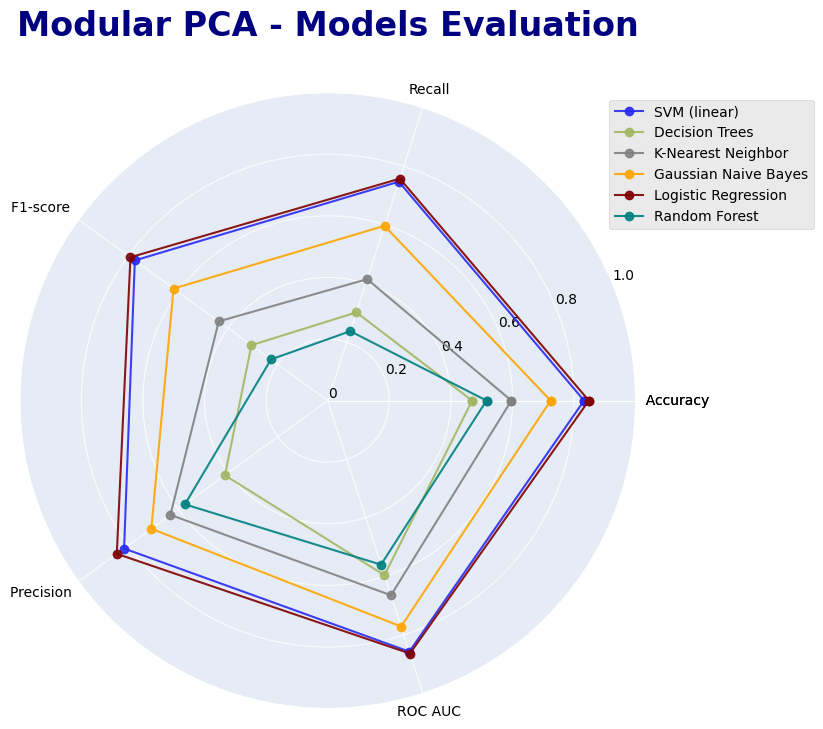

In [165]:
plt.style.use('ggplot')
# Data
labels = [(' '*10 +'Accuracy'), 'Recall', ('F1-score'+ ' ' * 10) , ('Precision'+ ' ' * 10), 'ROC AUC']

svm = final_results_df.loc['SVM',['Accuracy', 'Recall', 'F1 Score', 'Precision', 'ROC AUC']].tolist()
dt = final_results_df.loc['Decision Tree',['Accuracy', 'Recall', 'F1 Score', 'Precision', 'ROC AUC']].tolist()
knn = final_results_df.loc['K-Nearest Neighbors',['Accuracy', 'Recall', 'F1 Score', 'Precision', 'ROC AUC']].tolist()
gnb = final_results_df.loc['Gaussian Naives Bayes',['Accuracy', 'Recall', 'F1 Score', 'Precision', 'ROC AUC']].tolist()
lr = final_results_df.loc['Logistic Regression',['Accuracy', 'Recall', 'F1 Score', 'Precision', 'ROC AUC']].tolist()
rf = final_results_df.loc['Random Forest',['Accuracy', 'Recall', 'F1 Score', 'Precision', 'ROC AUC']].tolist()

# Number of variables we're plotting.
categories = labels
N = len(categories)

# What will be the angle of each axis in the plot?
angles = np.linspace(0, 2*np.pi, len(labels), endpoint = False)
angles = np.concatenate((angles, [angles[0]]))


# Initialise the spider plot
plt.figure(figsize=(8, 8))  # Increase the size of the radar

# Draw one axe per variable + add labels yet
plt.xticks(angles[:-1], categories, color='white')  # White labels
plt.yticks([i/10 for i in range(11)], ["{:.2f}".format(i/10) for i in range(11)], color="white", size=7)
plt.ylim(0, 1)

# Set gray background
ax = plt.subplot(111, polar=True, facecolor='#E6ECF5', alpha = 0.7)  

# Plot each classifier's data
for data, label, color in zip([svm, dt, knn, gnb, lr, rf],
                              ["SVM (linear)", "Decision Trees", "K-Nearest Neighbor",
                               "Gaussian Naive Bayes", "Logistic Regression", "Random Forest"],
                              ['#292AF4', '#A3B763', '#818181', 'orange', 'maroon', 'teal']):
 
    ax.plot(angles, data + data[:1], 'o-', linewidth=1.5, label=label, color=color, alpha = 0.9)
    ax.fill(angles, data + data[:1], alpha=0)  # Fill only the edges
    
# Modify grids
labels.append(labels[0])
ax.set_thetagrids(angles * 180/np.pi, labels, color = 'black')
plt.grid(True)

# Add labels for each coordinate system
# for angle, lab in zip(angles, labels):
# plt.annotate(labels[0], xy=(angles[0], 1.1), color='white', fontsize=10, ha='center')
# plt.annotate(labels[1], xy=(angles[1], 1.1), color='white', fontsize=10, ha='center')
# plt.annotate(labels[2], xy=(angles[2], 1.1), color='white', fontsize=10, ha='center')
# plt.annotate(labels[3], xy=(angles[3], 1.1), color='white', fontsize=10, ha='center')

plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
plt.title("Modular PCA - Models Evaluation\n", size = 24,color='navy', weight = 'bold')
plt.grid(color='white', linestyle='-', alpha = 0.8)  # White grid lines
plt.yticks([0,0.2, 0.4, 0.6, 0.8, 1.0], ["0","0.2", "0.4", "0.6", "0.8", "1.0"],color="black", size=10)  # Custom y-ticks
plt.show()


In [166]:
# dump prediction results
import json
predictions = {}
for k in prediction_results.keys():
    predictions[k] = list(prediction_results[k])

# with open("/kaggle/working/prediction_results.json", "w") as json_file:
#     json.dump(predictions, json_file)

predictions

{'svc': [1,
  1,
  3,
  3,
  1,
  3,
  3,
  3,
  3,
  1,
  3,
  0,
  4,
  5,
  3,
  3,
  3,
  5,
  4,
  3,
  3,
  4,
  1,
  4,
  3,
  1,
  1,
  3,
  3,
  1,
  1,
  3,
  2,
  1,
  1,
  4,
  2,
  1,
  1,
  3,
  3,
  1,
  1,
  3,
  5,
  6,
  1,
  2,
  3,
  3,
  3,
  0,
  1,
  1,
  3,
  0,
  3,
  0,
  3,
  3,
  1,
  4,
  3,
  3,
  1,
  3,
  3,
  1,
  6,
  3,
  1,
  3,
  1,
  2,
  3,
  6,
  6,
  3,
  6,
  3,
  3,
  1,
  3,
  1,
  0,
  4,
  2,
  1,
  5,
  3,
  3,
  2,
  6,
  3,
  3,
  1,
  2,
  3,
  3,
  3,
  1,
  3,
  5,
  4,
  3,
  3,
  3,
  1,
  3,
  3,
  1,
  3,
  3,
  3,
  3,
  2,
  3,
  1,
  3,
  3,
  0,
  1,
  1,
  3,
  2,
  2,
  1,
  3,
  3,
  3,
  5,
  6,
  2,
  2,
  1,
  3,
  3,
  1,
  3,
  0,
  6,
  3,
  3,
  3,
  1,
  2,
  6,
  3,
  6,
  3,
  1,
  1,
  3,
  1,
  2,
  3,
  3,
  3,
  6,
  3,
  3,
  6,
  6,
  3,
  3,
  3,
  3,
  2,
  6,
  3,
  3,
  3,
  4,
  3,
  2,
  3,
  1,
  1,
  3,
  3,
  0,
  1,
  3,
  6,
  2,
  6,
  3,
  4,
  3,
  6,
  0,
  3,
  0,
  2,
  3,
  3,
  4,
  4,
  1